<a href="https://colab.research.google.com/github/KKOUWE/NumMet-Network-Design-Physarum-polycephalum-Ph/blob/main/Gravity_Based_Model_France_Maps_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traffic Flows (F_ij) between nodes (normalized):
From A to B: 0.6455
From A to C: 0.7454
From A to D: 0.7071
From B to C: 0.9129
From B to D: 0.8660
From C to D: 1.0000


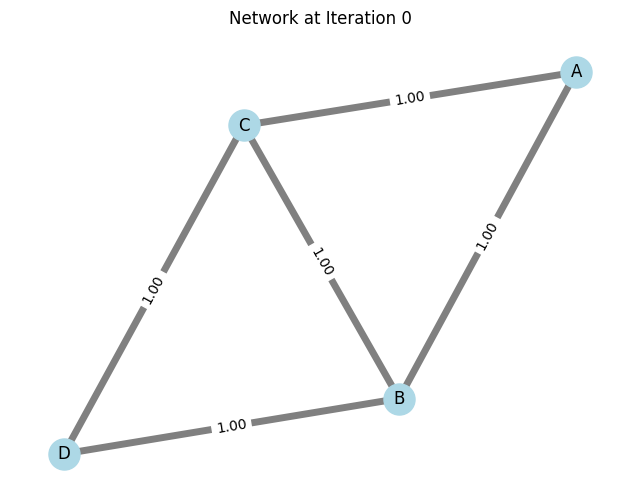

Iteration 1, max_change: 0.09332095007419405
Iteration 2, max_change: 0.08402519952770038
Iteration 3, max_change: 0.07566235469883098
Iteration 4, max_change: 0.06813935600930332
Iteration 5, max_change: 0.0613724512118462
Iteration 6, max_change: 0.05528626148796889
Iteration 7, max_change: 0.049812940397598426
Iteration 8, max_change: 0.0448914164061161
Iteration 9, max_change: 0.04046671066877133
Iteration 10, max_change: 0.036489322616302944
Iteration 11, max_change: 0.03291467666677561
Iteration 12, max_change: 0.02970262409356811
Iteration 13, max_change: 0.026816994713141584
Iteration 14, max_change: 0.024225193622540664
Iteration 15, max_change: 0.02189783871855122
Iteration 16, max_change: 0.019808435170696498
Iteration 17, max_change: 0.0179330834015346
Iteration 18, max_change: 0.016250217453409987
Iteration 19, max_change: 0.01474037089540256
Iteration 20, max_change: 0.013385967653593234
Iteration 21, max_change: 0.012171135339285488
Iteration 22, max_change: 0.0110815388

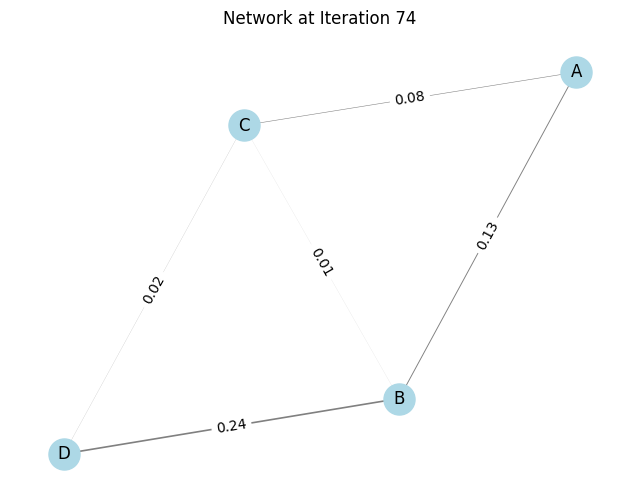


Final Conductivities (D_ij) on edges:
Edge A-B: D_ij = 0.1341
Edge A-C: D_ij = 0.0764
Edge B-C: D_ij = 0.0095
Edge B-D: D_ij = 0.2383
Edge C-D: D_ij = 0.0197


In [ ]:
# ================================================
# Gravity Based Model 1: Physarum Network Design
# ================================================

# This script implements a network design algorithm inspired by the Physarum Polycephalum slime mold.
# It combines the Physarum algorithm with the gravity model to simulate the formation of efficient
# transportation networks based on traffic flows between cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with an associated GDP (Gross Domestic Product)
G.add_node('A', GDP=100)  # City A with GDP of 100 million
G.add_node('B', GDP=150)  # City B with GDP of 150 million
G.add_node('C', GDP=200)  # City C with GDP of 200 million
G.add_node('D', GDP=180)  # City D with GDP of 180 million

# Add edges representing possible connections between cities, each with an associated length (distance)
G.add_edge('A', 'B', length=10)  # Edge between A and B with length 10 km
G.add_edge('B', 'C', length=15)  # Edge between B and C with length 15 km
G.add_edge('A', 'C', length=20)  # Edge between A and C with length 20 km
G.add_edge('B', 'D', length=12)  # Edge between B and D with length 12 km
G.add_edge('C', 'D', length=8)   # Edge between C and D with length 8 km

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 0    # Exponent for distance (set to 0 as per the assumption)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes())     # List of all nodes (cities)

    for i in nodes:
        for j in nodes:
            if i != j and i < j:  # Only consider one direction to avoid symmetry (i < j)
                GDP_i = G.nodes[i]['GDP']
                GDP_j = G.nodes[j]['GDP']
                # Since alpha3 = 0, the distance term is effectively 1
                distance = 1
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (distance ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in traffic_flows.items():
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Increased decay rate to prevent conductivities from growing indefinitely
delta_t = 0.01      # Decreased time step to reduce changes per iteration
max_iterations = 1000  # Increased maximum number of iterations
tolerance = 1e-3    # Increased tolerance for convergence

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'D'                             # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)         # Generate positions for nodes using a force-directed layout
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey')
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Add edge labels showing the conductivity values
    edge_labels = {(u, v): f"{data['D_ij']:.2f}" for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    # Add a title indicating the iteration number
    plt.title(f"Network at Iteration {iteration}")
    plt.axis('off')                            # Turn off the axis
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Print the maximum change in conductivities for monitoring convergence
    print(f"Iteration {iteration}, max_change: {max_change}")
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")


Traffic Flows (F_ij) between nodes (normalized):
From Berlin to Paris: 0.2769
From Berlin to London: 0.3194
From Berlin to Rome: 0.1524
From Berlin to Madrid: 0.1048
From Berlin to Amsterdam: 0.2982
From Berlin to Stockholm: 0.1896
From Berlin to Warsaw: 0.2573
From Berlin to Vienna: 0.2745
From Berlin to Zurich: 0.2436
From Paris to London: 1.0000


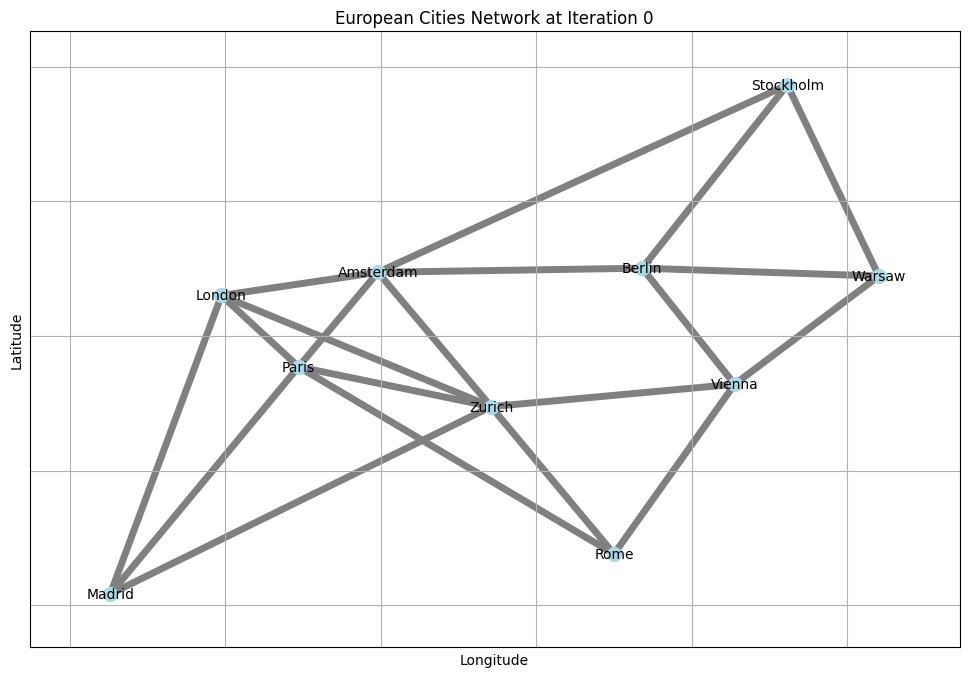

Converged after 55 iterations.


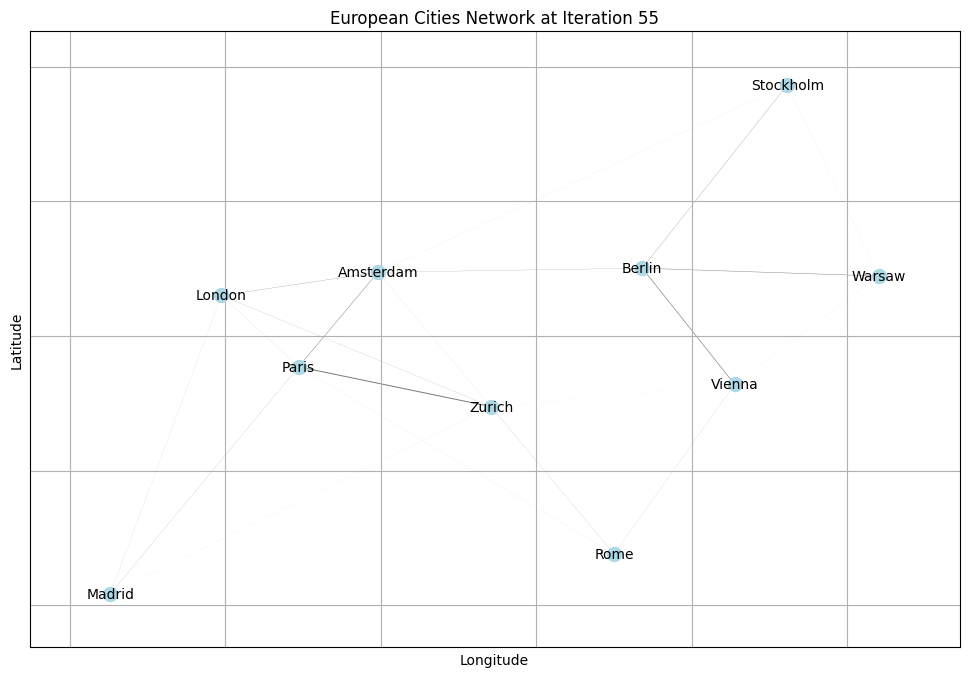


Final Conductivities (D_ij) on edges:
Edge Berlin-Warsaw: D_ij = 0.0663
Edge Berlin-Vienna: D_ij = 0.0923
Edge Berlin-Amsterdam: D_ij = 0.0268
Edge Berlin-Stockholm: D_ij = 0.0377
Edge Paris-London: D_ij = 0.0112
Edge Paris-Amsterdam: D_ij = 0.0652
Edge Paris-Zurich: D_ij = 0.1482
Edge Paris-Rome: D_ij = 0.0059
Edge Paris-Madrid: D_ij = 0.0201
Edge London-Amsterdam: D_ij = 0.0358
Edge London-Zurich: D_ij = 0.0208
Edge London-Madrid: D_ij = 0.0104
Edge Rome-Zurich: D_ij = 0.0182
Edge Rome-Vienna: D_ij = 0.0143
Edge Madrid-Zurich: D_ij = 0.0046
Edge Amsterdam-Stockholm: D_ij = 0.0063
Edge Amsterdam-Zurich: D_ij = 0.0082
Edge Stockholm-Warsaw: D_ij = 0.0055
Edge Warsaw-Vienna: D_ij = 0.0044
Edge Vienna-Zurich: D_ij = 0.0033


In [ ]:
# ================================================
# Gravity Based Model 1: European Cities Network
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a simplified map of Europe with 10 major cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP and coordinates
cities = {
    'Berlin': {'GDP': 150, 'lat': 52.5200, 'lon': 13.4050},
    'Paris': {'GDP': 200, 'lat': 48.8566, 'lon': 2.3522},
    'London': {'GDP': 300, 'lat': 51.5074, 'lon': -0.1278},
    'Rome': {'GDP': 110, 'lat': 41.9028, 'lon': 12.4964},
    'Madrid': {'GDP': 130, 'lat': 40.4168, 'lon': -3.7038},
    'Amsterdam': {'GDP': 100, 'lat': 52.3676, 'lon': 4.9041},
    'Stockholm': {'GDP': 80, 'lat': 59.3293, 'lon': 18.0686},
    'Warsaw': {'GDP': 60, 'lat': 52.2297, 'lon': 21.0122},
    'Vienna': {'GDP': 70, 'lat': 48.2082, 'lon': 16.3738},
    'Zurich': {'GDP': 90, 'lat': 47.3769, 'lon': 8.5417},
}

# Add the cities as nodes in the graph
for city, data in cities.items():
    G.add_node(city, GDP=data['GDP'], lat=data['lat'], lon=data['lon'])

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities (you can connect all pairs or define specific connections)
# For simplicity, we'll connect each city to its nearest neighbors.

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate to prevent conductivities from growing indefinitely
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'Zurich'                        # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey')
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    # Add edge labels showing the conductivity values (optional)
    # edge_labels = {(u, v): f"{data['D_ij']:.2f}" for u, v, data in G.edges(data=True)}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    # Add a title indicating the iteration number
    plt.title(f"European Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Print the maximum change in conductivities for monitoring convergence
    # print(f"Iteration {iteration}, max_change: {max_change}")
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Marseille: 0.4219
From Paris to Lyon: 0.7905
From Paris to Toulouse: 0.4536
From Paris to Nice: 0.3600
From Paris to Nantes: 0.7785
From Paris to Strasbourg: 0.4959
From Paris to Montpellier: 0.3421
From Paris to Bordeaux: 0.5809
From Paris to Lille: 1.0000
From Marseille to Lyon: 0.3264


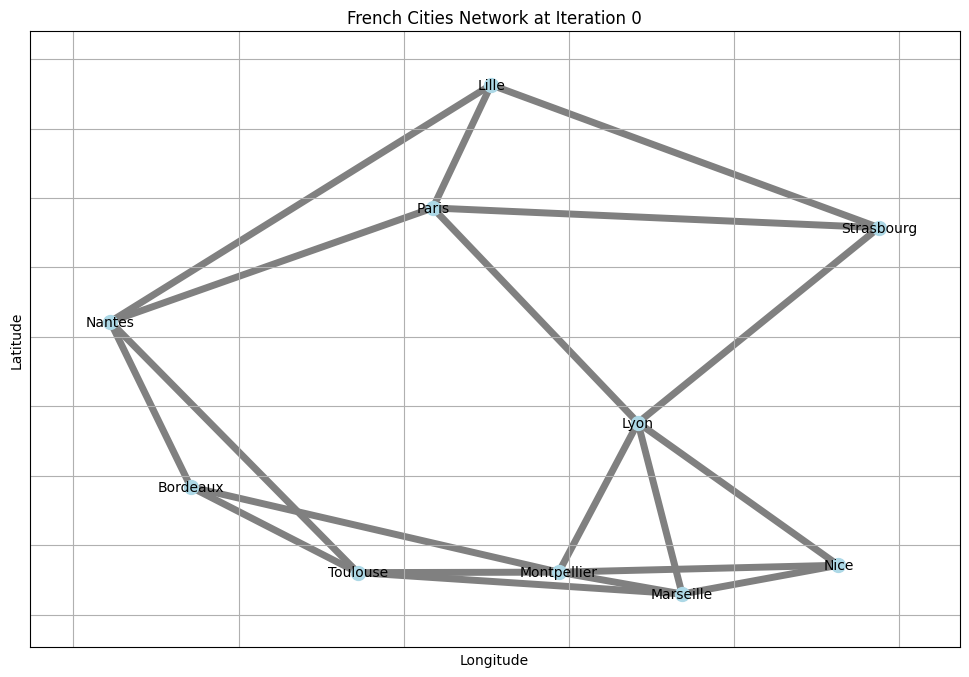

Converged after 70 iterations.


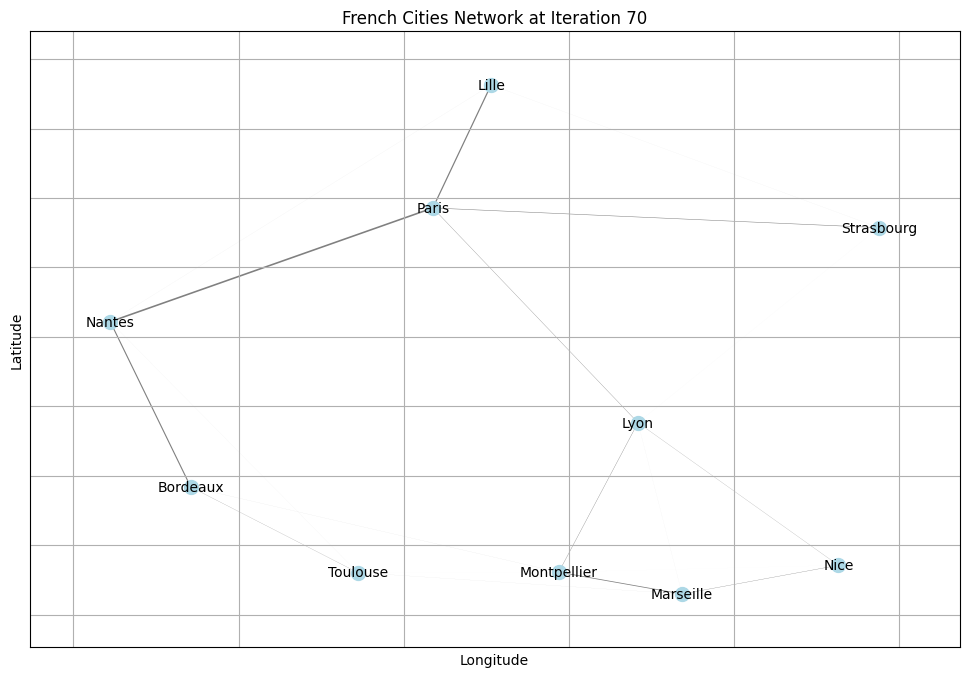


Final Conductivities (D_ij) on edges:
Edge Paris-Lille: D_ij = 0.1756
Edge Paris-Nantes: D_ij = 0.2319
Edge Paris-Lyon: D_ij = 0.0449
Edge Paris-Strasbourg: D_ij = 0.0721
Edge Marseille-Montpellier: D_ij = 0.1091
Edge Marseille-Nice: D_ij = 0.0419
Edge Marseille-Lyon: D_ij = 0.0032
Edge Marseille-Toulouse: D_ij = 0.0056
Edge Lyon-Montpellier: D_ij = 0.0486
Edge Lyon-Nice: D_ij = 0.0265
Edge Lyon-Strasbourg: D_ij = 0.0014
Edge Toulouse-Montpellier: D_ij = 0.0010
Edge Toulouse-Bordeaux: D_ij = 0.0275
Edge Toulouse-Nantes: D_ij = 0.0032
Edge Nice-Montpellier: D_ij = 0.0011
Edge Nantes-Bordeaux: D_ij = 0.1601
Edge Nantes-Lille: D_ij = 0.0038
Edge Strasbourg-Lille: D_ij = 0.0040
Edge Montpellier-Bordeaux: D_ij = 0.0058


In [ ]:
# ================================================
# Gravity Based Model 1: French Cities Network
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a simplified map of France with 10 major cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP and coordinates
cities = {
    'Paris': {'GDP': 700, 'lat': 48.8566, 'lon': 2.3522},
    'Marseille': {'GDP': 60, 'lat': 43.2965, 'lon': 5.3698},
    'Lyon': {'GDP': 74, 'lat': 45.7640, 'lon': 4.8357},
    'Toulouse': {'GDP': 55, 'lat': 43.6047, 'lon': 1.4442},
    'Nice': {'GDP': 47, 'lat': 43.7102, 'lon': 7.2620},
    'Nantes': {'GDP': 55, 'lat': 47.2184, 'lon': -1.5536},
    'Strasbourg': {'GDP': 30, 'lat': 48.5734, 'lon': 7.7521},
    'Montpellier': {'GDP': 32, 'lat': 43.6108, 'lon': 3.8767},
    'Bordeaux': {'GDP': 65, 'lat': 44.8378, 'lon': -0.5792},
    'Lille': {'GDP': 32, 'lat': 50.6292, 'lon': 3.0573},
}

# Add the cities as nodes in the graph
for city, data in cities.items():
    G.add_node(city, GDP=data['GDP'], lat=data['lat'], lon=data['lon'])

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate to prevent conductivities from growing indefinitely
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'Paris'                         # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='grey')
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    # Add edge labels showing the conductivity values (optional)
    # edge_labels = {(u, v): f"{data['D_ij']:.2f}" for u, v, data in G.edges(data=True)}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    # Add a title indicating the iteration number
    plt.title(f"French Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Print the maximum change in conductivities for monitoring convergence
    # print(f"Iteration {iteration}, max_change: {max_change}")
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Marseille: 0.3723
From Paris to Lyon: 0.5532
From Paris to Toulouse: 0.2868
From Paris to Nantes: 0.4743
From Paris to Bordeaux: 0.3443
From Paris to Lille: 1.0000
From Marseille to Lyon: 0.3123
From Marseille to Toulouse: 0.2118
From Marseille to Nantes: 0.0936
From Marseille to Bordeaux: 0.1362


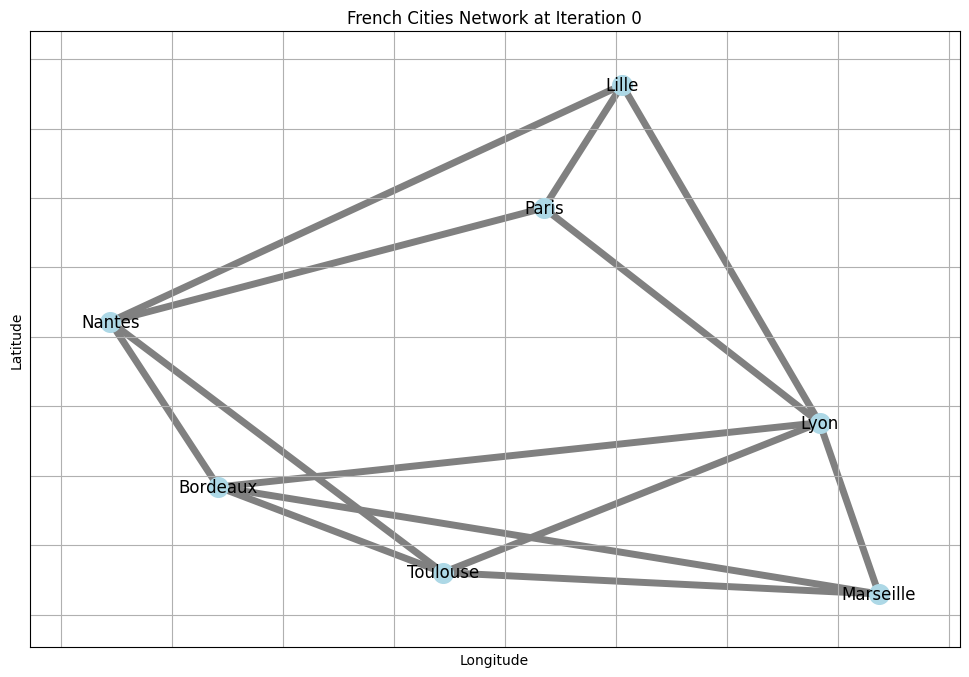

Converged after 49 iterations.


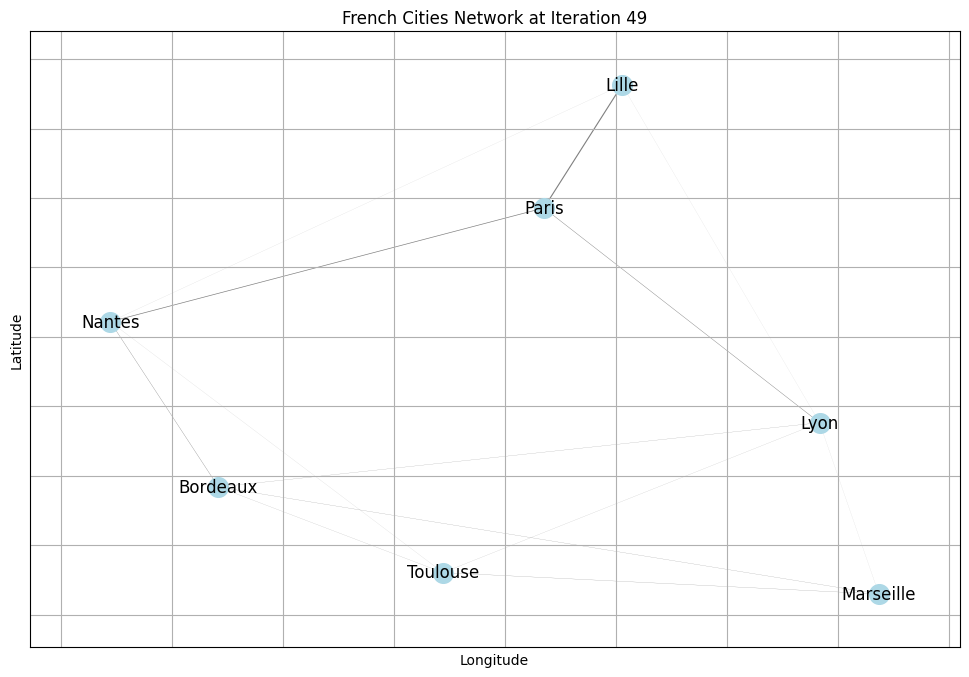


Final Conductivities (D_ij) on edges:
Edge Paris-Lille: D_ij = 0.1611
Edge Paris-Nantes: D_ij = 0.0971
Edge Paris-Lyon: D_ij = 0.0604
Edge Marseille-Lyon: D_ij = 0.0095
Edge Marseille-Toulouse: D_ij = 0.0291
Edge Marseille-Bordeaux: D_ij = 0.0262
Edge Lyon-Toulouse: D_ij = 0.0167
Edge Lyon-Bordeaux: D_ij = 0.0244
Edge Lyon-Lille: D_ij = 0.0089
Edge Toulouse-Bordeaux: D_ij = 0.0187
Edge Toulouse-Nantes: D_ij = 0.0117
Edge Nantes-Bordeaux: D_ij = 0.0456
Edge Nantes-Lille: D_ij = 0.0103


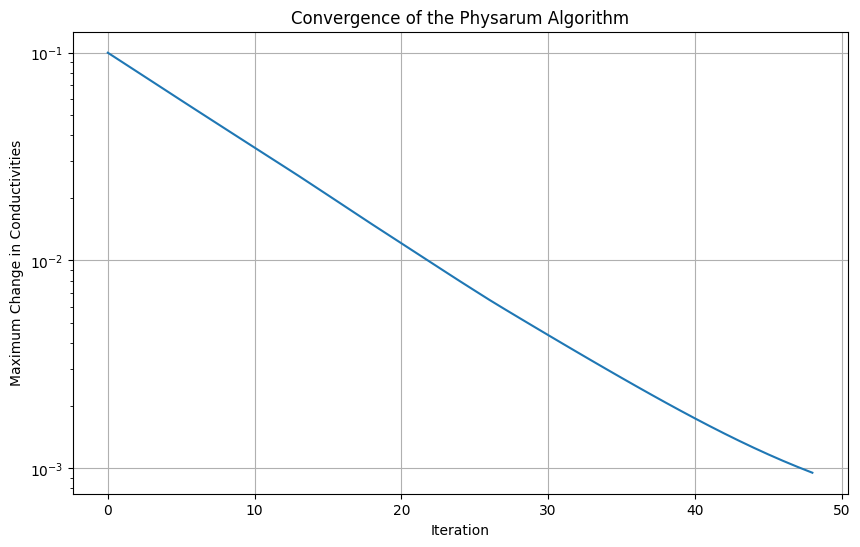

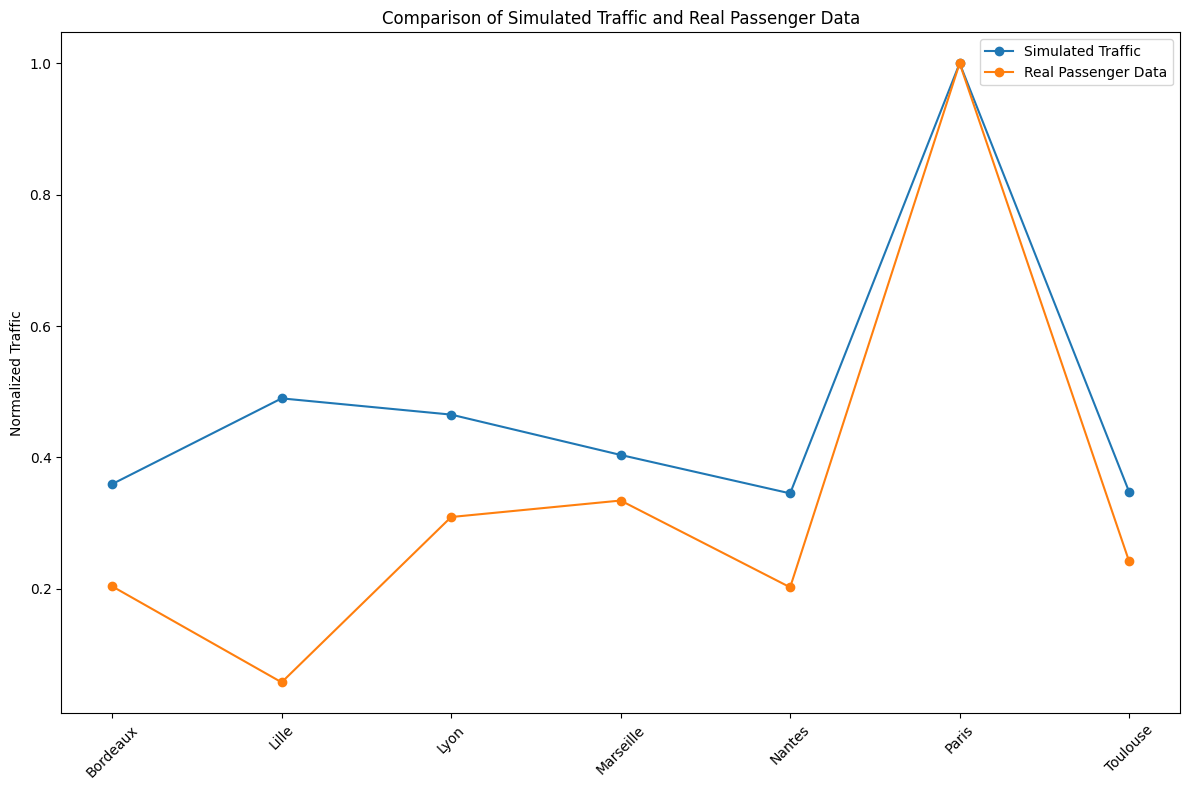

Correlation coefficient between simulated traffic and real passenger data: 0.9084


In [2]:
# ================================================
# Gravity Based Model 1: French Cities Network
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a simplified map of France with major cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP and coordinates
cities = {
    'Paris': {'GDP': 782.6, 'lat': 48.8566, 'lon': 2.3522},
    'Marseille': {'GDP': 125.4, 'lat': 43.2965, 'lon': 5.3698},
    'Lyon': {'GDP': 97.3, 'lat': 45.7640, 'lon': 4.8357},
    'Toulouse': {'GDP': 59.0, 'lat': 43.6047, 'lon': 1.4442},
    'Nantes': {'GDP': 54.8, 'lat': 47.2184, 'lon': -1.5536},
    'Bordeaux': {'GDP': 61.3, 'lat': 44.8378, 'lon': -0.5792},
    'Lille': {'GDP': 85.9, 'lat': 50.6292, 'lon': 3.0573},
}

# Add the cities as nodes in the graph
for city, data in cities.items():
    G.add_node(city, GDP=data['GDP'], lat=data['lat'], lon=data['lon'])

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge (reverted to original)
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate reverted to original value
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Lists to store data for plotting
max_changes = []    # To store the maximum change in conductivities at each iteration
conductivity_history = {}  # To store conductivities over time

# Initialize conductivity history
for u, v in G.edges():
    conductivity_history[(u, v)] = [G[u][v]['D_ij']]

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'Paris'                         # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Record the conductivity history
        conductivity_history[(u, v)].append(D_ij_new)
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]
    # Edge colors set back to grey
    edge_colors = ['grey' for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Add a title indicating the iteration number
    plt.title(f"French Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Record the maximum change for plotting
    max_changes.append(max_change)
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")

# ------------------------------------------------
# Step 5: Plotting Convergence Metrics
# ------------------------------------------------

# Plot the maximum change in conductivities over iterations
plt.figure(figsize=(10, 6))
plt.plot(max_changes)
plt.title("Convergence of the Physarum Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Maximum Change in Conductivities")
plt.yscale('log')
plt.grid(True)
plt.show()

# ------------------------------------------------
# Step 6: Compare Simulated Traffic with Real Data
# ------------------------------------------------

# Sum the traffic flows for each city (simulated data)
city_traffic_simulation = {city: 0.0 for city in G.nodes()}
for (origin, dest), flow in traffic_flows.items():
    city_traffic_simulation[origin] += flow
    city_traffic_simulation[dest] += flow

# Real passenger data for each city
city_passengers = {
    'Paris': 32294167,     # Updated passenger number for Paris
    'Marseille': 10800254,
    'Lyon': 9989867,
    'Lille': 1864769,
    'Bordeaux': 6584194,
    'Toulouse': 7804980,
    'Nantes': 6535074,
}

# Normalize both datasets
max_simulated_traffic = max(city_traffic_simulation.values())
normalized_simulated_traffic = {city: flow / max_simulated_traffic for city, flow in city_traffic_simulation.items()}

max_passenger_traffic = max(city_passengers.values())
normalized_passenger_traffic = {city: passengers / max_passenger_traffic for city, passengers in city_passengers.items()}

# Ensure both datasets have the same cities
cities_list = sorted(G.nodes())

# Extract values in order
simulated_values = [normalized_simulated_traffic[city] for city in cities_list]
passenger_values = [normalized_passenger_traffic[city] for city in cities_list]

# Plot the comparison using line plots with dots
plt.figure(figsize=(12, 8))
x = np.arange(len(cities_list))  # the label locations

# Plot simulated traffic
plt.plot(x, simulated_values, marker='o', label='Simulated Traffic', linestyle='-')

# Plot real passenger data
plt.plot(x, passenger_values, marker='o', label='Real Passenger Data', linestyle='-')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Normalized Traffic')
plt.title('Comparison of Simulated Traffic and Real Passenger Data')
plt.xticks(x, cities_list, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Calculate and print the correlation coefficient
simulated_array = np.array(simulated_values)
passenger_array = np.array(passenger_values)
correlation = np.corrcoef(simulated_array, passenger_array)[0, 1]
print(f"Correlation coefficient between simulated traffic and real passenger data: {correlation:.4f}")


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Marseille: 0.4219
From Paris to Lyon: 0.7905
From Paris to Toulouse: 0.4536
From Paris to Nice: 0.3600
From Paris to Nantes: 0.7785
From Paris to Strasbourg: 0.4959
From Paris to Montpellier: 0.3421
From Paris to Bordeaux: 0.5809
From Paris to Lille: 1.0000
From Marseille to Paris: 0.4219


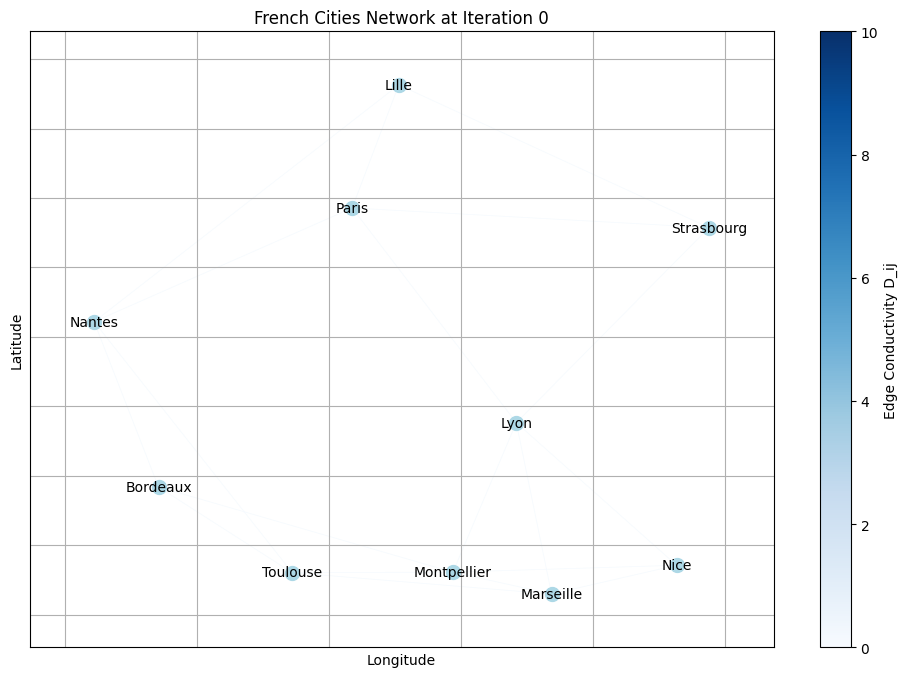

Converged after 23 iterations.


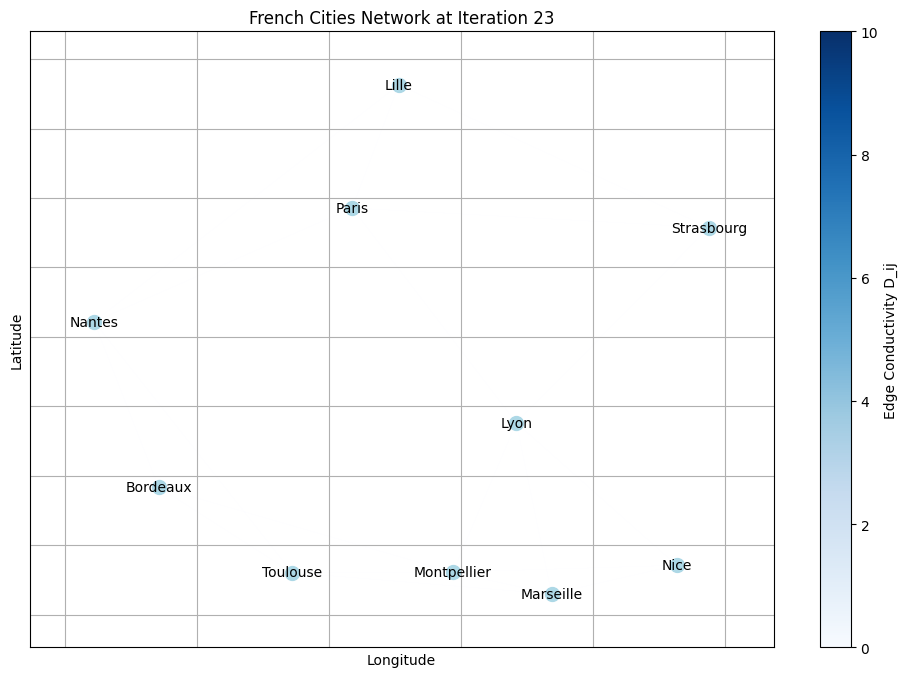


Final Conductivities (D_ij) on edges:
Edge Paris-Lille: D_ij = 0.0089
Edge Paris-Nantes: D_ij = 0.0089
Edge Paris-Lyon: D_ij = 0.0089
Edge Paris-Strasbourg: D_ij = 0.0089
Edge Marseille-Montpellier: D_ij = 0.0089
Edge Marseille-Nice: D_ij = 0.0089
Edge Marseille-Lyon: D_ij = 0.0089
Edge Marseille-Toulouse: D_ij = 0.0089
Edge Lyon-Montpellier: D_ij = 0.0089
Edge Lyon-Nice: D_ij = 0.0089
Edge Lyon-Strasbourg: D_ij = 0.0089
Edge Toulouse-Montpellier: D_ij = 0.0089
Edge Toulouse-Bordeaux: D_ij = 0.0089
Edge Toulouse-Nantes: D_ij = 0.0089
Edge Nice-Montpellier: D_ij = 0.0089
Edge Nantes-Bordeaux: D_ij = 0.0089
Edge Nantes-Lille: D_ij = 0.0089
Edge Strasbourg-Lille: D_ij = 0.0089
Edge Montpellier-Bordeaux: D_ij = 0.0089


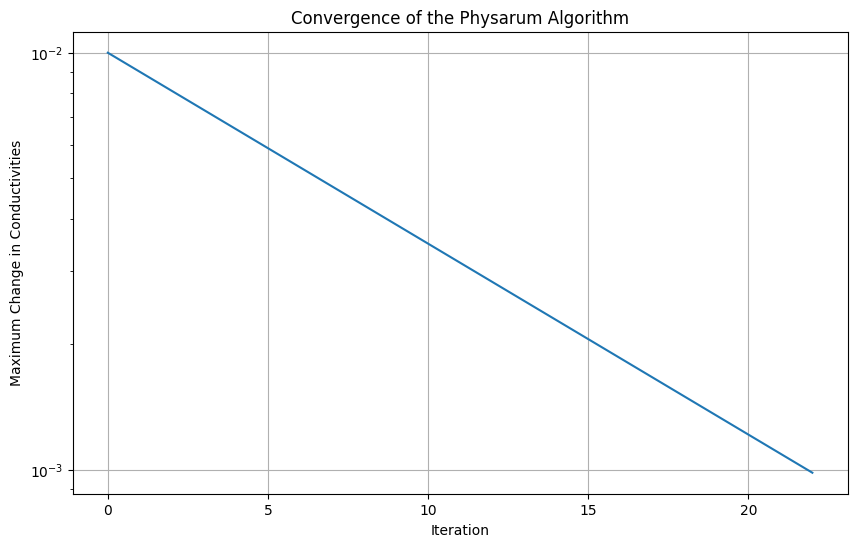

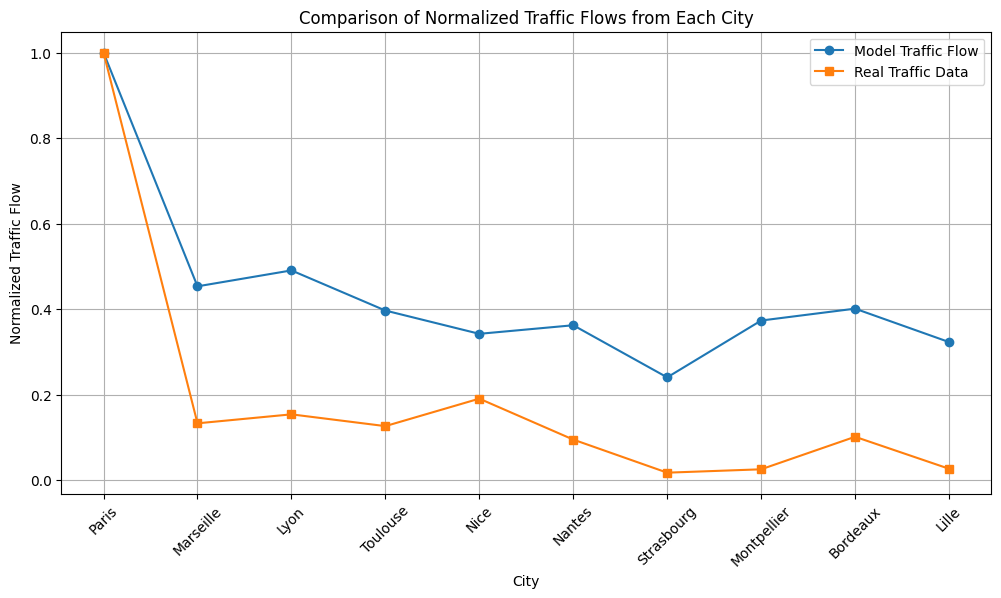

Correlation coefficient between model and real data: 0.9644


In [ ]:
# ================================================
# Gravity Based Model 1: French Cities Network
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a simplified map of France with 10 major cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP and coordinates
cities = {
    'Paris': {'GDP': 700, 'lat': 48.8566, 'lon': 2.3522},
    'Marseille': {'GDP': 60, 'lat': 43.2965, 'lon': 5.3698},
    'Lyon': {'GDP': 74, 'lat': 45.7640, 'lon': 4.8357},
    'Toulouse': {'GDP': 55, 'lat': 43.6047, 'lon': 1.4442},
    'Nice': {'GDP': 47, 'lat': 43.7102, 'lon': 7.2620},
    'Nantes': {'GDP': 55, 'lat': 47.2184, 'lon': -1.5536},
    'Strasbourg': {'GDP': 30, 'lat': 48.5734, 'lon': 7.7521},
    'Montpellier': {'GDP': 32, 'lat': 43.6108, 'lon': 3.8767},
    'Bordeaux': {'GDP': 65, 'lat': 44.8378, 'lon': -0.5792},
    'Lille': {'GDP': 32, 'lat': 50.6292, 'lon': 3.0573},
}

# Add the cities as nodes in the graph
for city, data in cities.items():
    G.add_node(city, GDP=data['GDP'], lat=data['lat'], lon=data['lon'])

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        total_flow = 0  # Total flow from city i
        for j, data_j in nodes:
            if i != j:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
                total_flow += F_ij
        # Store the total flow from city i
        G.nodes[i]['total_flow'] = total_flow

    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Also normalize the total flows from each city
total_flows = {city: data['total_flow'] for city, data in G.nodes(data=True)}
max_total_flow = max(total_flows.values())
normalized_total_flows = {city: flow / max_total_flow for city, flow in total_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 0.1          # Start with a smaller initial conductivity
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate to prevent conductivities from growing indefinitely
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence
D_ij_max = 10.0     # Maximum allowable conductivity to prevent unbounded growth

# Lists to store data for plotting
max_changes = []    # To store the maximum change in conductivities at each iteration
conductivity_history = {}  # To store conductivities over time

# Initialize conductivity history
for u, v in G.edges():
    conductivity_history[(u, v)] = [G[u][v]['D_ij']]

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'Paris'                         # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Record the conductivity history
        conductivity_history[(u, v)].append(D_ij_new)
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]
    # Edge colors based on conductivity
    edge_conductivities = [data['D_ij'] for _, _, data in G.edges(data=True)]

    # Draw the edges with scaled widths and colors
    edge_collection = nx.draw_networkx_edges(
        G, pos, width=edge_widths, edge_color=edge_conductivities, edge_cmap=plt.cm.Blues,
        edge_vmin=0, edge_vmax=D_ij_max, ax=ax
    )
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', ax=ax)
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', ax=ax)
    # Add a colorbar associated with the edges
    cbar = plt.colorbar(edge_collection, ax=ax)
    cbar.set_label('Edge Conductivity D_ij')
    # Add a title indicating the iteration number
    ax.set_title(f"French Cities Network at Iteration {iteration}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis('on')                            # Show axis
    ax.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Record the maximum change for plotting
    max_changes.append(max_change)
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")

# ------------------------------------------------
# Step 5: Plotting Convergence Metrics
# ------------------------------------------------

# Plot the maximum change in conductivities over iterations
plt.figure(figsize=(10, 6))
plt.plot(max_changes)
plt.title("Convergence of the Physarum Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Maximum Change in Conductivities")
plt.yscale('log')
plt.grid(True)
plt.show()

# ------------------------------------------------
# Step 6: Compare Model Traffic Flow with Real Data
# ------------------------------------------------

# Real traffic data (annual passengers in millions for airports as a proxy)
# Data source: Official airport statistics (approximate values)
real_traffic_data = {
    'Paris': 76.2,       # Paris Charles de Gaulle Airport
    'Marseille': 10.1,   # Marseille Provence Airport
    'Lyon': 11.7,        # Lyon-Saint Exupéry Airport
    'Toulouse': 9.6,     # Toulouse-Blagnac Airport
    'Nice': 14.5,        # Nice Côte d'Azur Airport
    'Nantes': 7.2,       # Nantes Atlantique Airport
    'Strasbourg': 1.3,   # Strasbourg Airport
    'Montpellier': 1.9,  # Montpellier–Méditerranée Airport
    'Bordeaux': 7.7,     # Bordeaux–Mérignac Airport
    'Lille': 2.0,        # Lille Airport
}

# Normalize the real traffic data
max_real_traffic = max(real_traffic_data.values())
normalized_real_traffic = {city: flow / max_real_traffic for city, flow in real_traffic_data.items()}

# Extract the model total flows from each city
model_total_flows = normalized_total_flows

# Prepare data for plotting
cities_list = list(cities.keys())
model_flows_list = [model_total_flows[city] for city in cities_list]
real_flows_list = [normalized_real_traffic[city] for city in cities_list]

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(cities_list, model_flows_list, marker='o', label='Model Traffic Flow')
plt.plot(cities_list, real_flows_list, marker='s', label='Real Traffic Data')
plt.title("Comparison of Normalized Traffic Flows from Each City")
plt.xlabel("City")
plt.ylabel("Normalized Traffic Flow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Calculate and display the correlation coefficient
correlation = np.corrcoef(model_flows_list, real_flows_list)[0, 1]
print(f"Correlation coefficient between model and real data: {correlation:.4f}")


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Marseille: 0.3723
From Paris to Lyon: 0.5532
From Paris to Toulouse: 0.2868
From Paris to Nantes: 0.4743
From Paris to Bordeaux: 0.3443
From Paris to Lille: 1.0000
From Marseille to Lyon: 0.3123
From Marseille to Toulouse: 0.2118
From Marseille to Nantes: 0.0936
From Marseille to Bordeaux: 0.1362


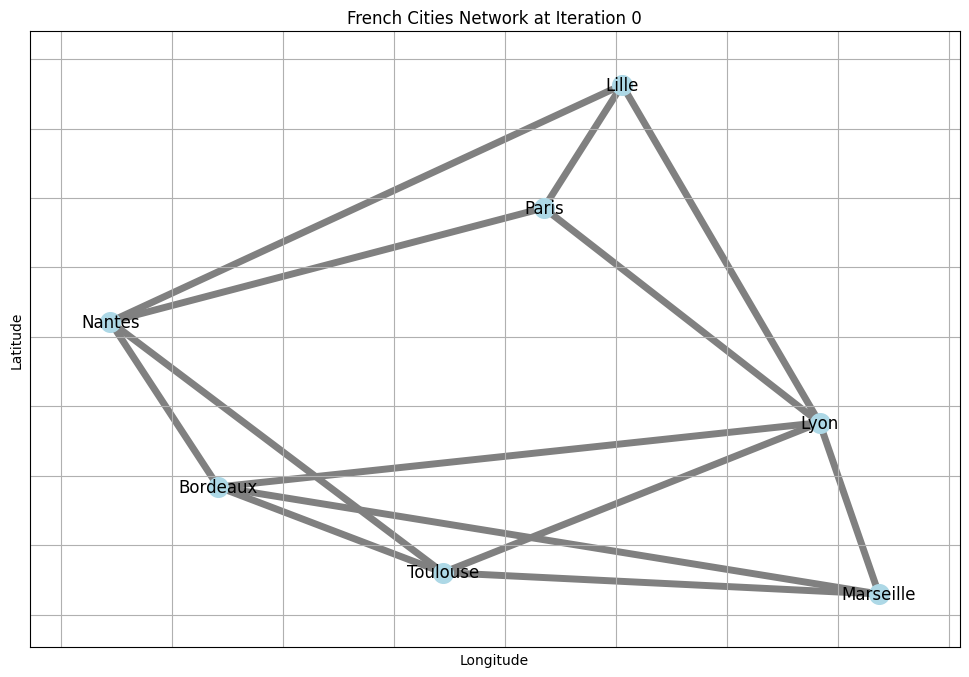

Converged after 49 iterations.


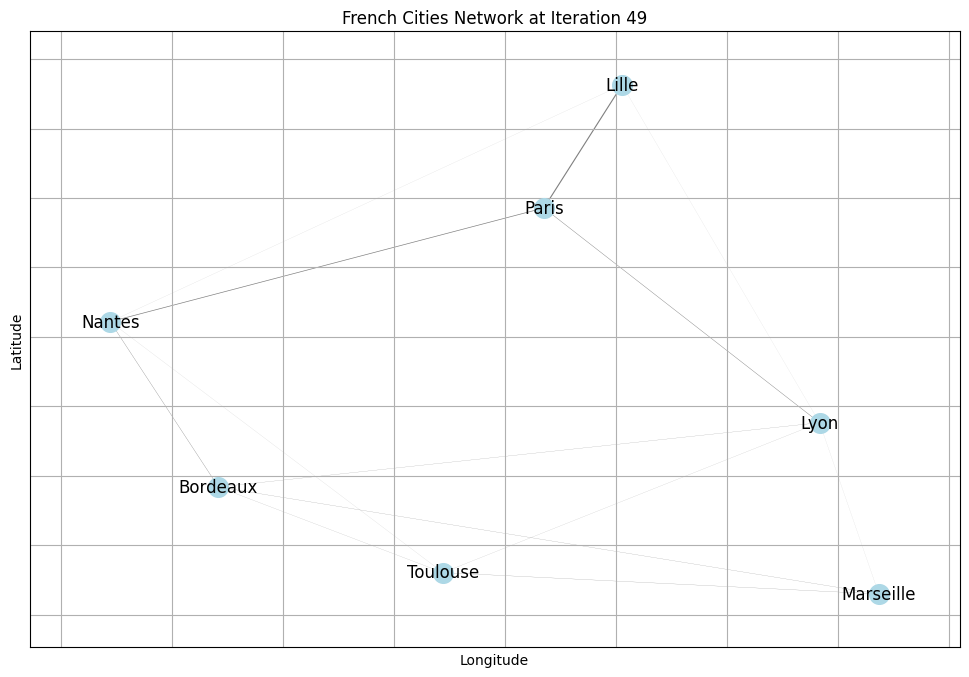


Final Conductivities (D_ij) on edges:
Edge Paris-Lille: D_ij = 0.1611
Edge Paris-Nantes: D_ij = 0.0971
Edge Paris-Lyon: D_ij = 0.0604
Edge Marseille-Lyon: D_ij = 0.0095
Edge Marseille-Toulouse: D_ij = 0.0291
Edge Marseille-Bordeaux: D_ij = 0.0262
Edge Lyon-Toulouse: D_ij = 0.0167
Edge Lyon-Bordeaux: D_ij = 0.0244
Edge Lyon-Lille: D_ij = 0.0089
Edge Toulouse-Bordeaux: D_ij = 0.0187
Edge Toulouse-Nantes: D_ij = 0.0117
Edge Nantes-Bordeaux: D_ij = 0.0456
Edge Nantes-Lille: D_ij = 0.0103


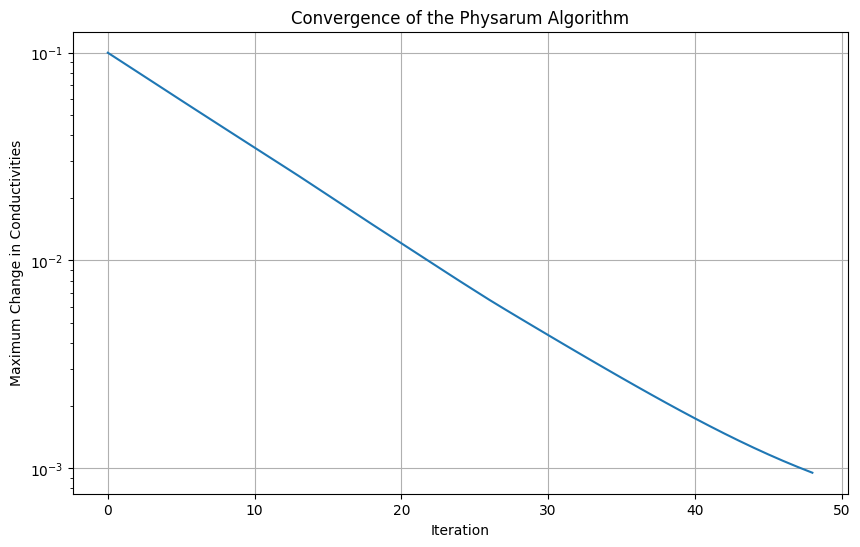

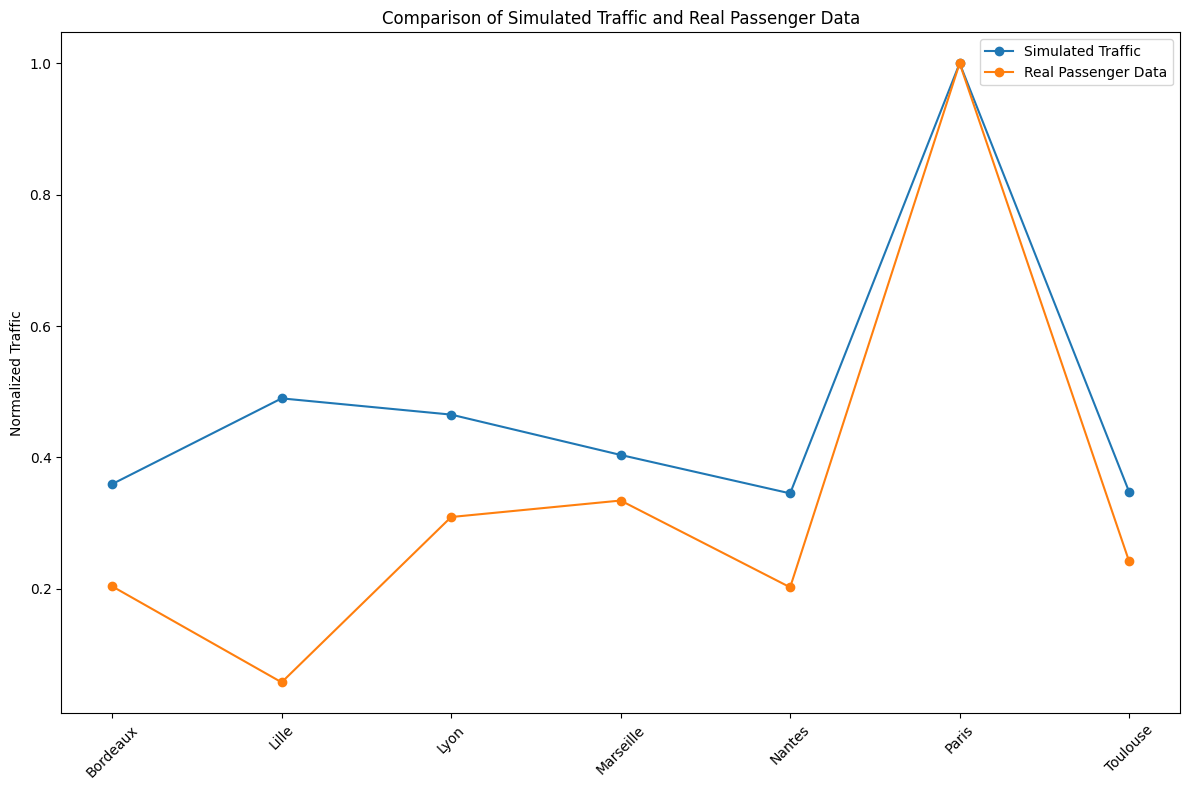

Correlation coefficient between simulated traffic and real passenger data: 0.9084


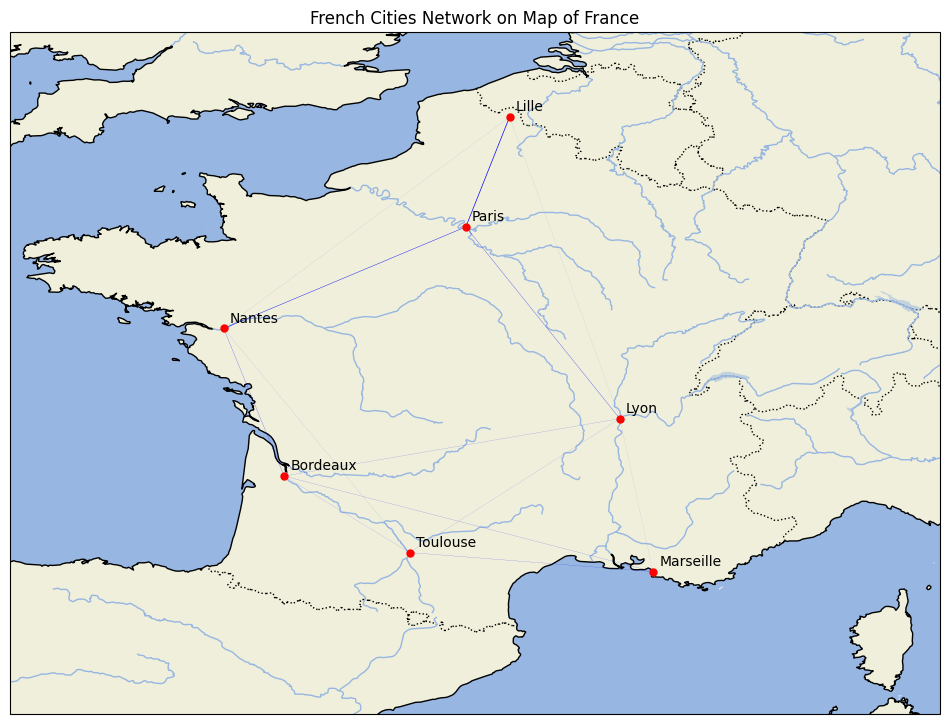

In [7]:
# ================================================
# Gravity Based Model 1: French Cities Network (maango2)
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a simplified map of France with major cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances
import cartopy.crs as ccrs      # For mapping
import cartopy.feature as cfeature  # For adding features to the map

# ------------------------------------------------
# Step 1: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP and coordinates
cities = {
    'Paris': {'GDP': 782.6, 'lat': 48.8566, 'lon': 2.3522},
    'Marseille': {'GDP': 125.4, 'lat': 43.2965, 'lon': 5.3698},
    'Lyon': {'GDP': 97.3, 'lat': 45.7640, 'lon': 4.8357},
    'Toulouse': {'GDP': 59.0, 'lat': 43.6047, 'lon': 1.4442},
    'Nantes': {'GDP': 54.8, 'lat': 47.2184, 'lon': -1.5536},
    'Bordeaux': {'GDP': 61.3, 'lat': 44.8378, 'lon': -0.5792},
    'Lille': {'GDP': 85.9, 'lat': 50.6292, 'lon': 3.0573},
}

# Add the cities as nodes in the graph
for city, data in cities.items():
    G.add_node(city, GDP=data['GDP'], lat=data['lat'], lon=data['lon'])

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 2: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 3: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Lists to store data for plotting
max_changes = []    # To store the maximum change in conductivities at each iteration
conductivity_history = {}  # To store conductivities over time

# Initialize conductivity history
for u, v in G.edges():
    conductivity_history[(u, v)] = [G[u][v]['D_ij']]

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = 'Paris'                         # Reference node (arbitrary choice)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Record the conductivity history
        conductivity_history[(u, v)].append(D_ij_new)
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]
    # Edge colors set to grey
    edge_colors = ['grey' for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Add a title indicating the iteration number
    plt.title(f"French Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Record the maximum change for plotting
    max_changes.append(max_change)
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# ------------------------------------------------
# Step 4: Display Final Results
# ------------------------------------------------

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")

# ------------------------------------------------
# Step 5: Plotting Convergence Metrics
# ------------------------------------------------

# Plot the maximum change in conductivities over iterations
plt.figure(figsize=(10, 6))
plt.plot(max_changes)
plt.title("Convergence of the Physarum Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Maximum Change in Conductivities")
plt.yscale('log')
plt.grid(True)
plt.show()

# ------------------------------------------------
# Step 6: Compare Simulated Traffic with Real Data
# ------------------------------------------------

# Sum the traffic flows for each city (simulated data)
city_traffic_simulation = {city: 0.0 for city in G.nodes()}
for (origin, dest), flow in traffic_flows.items():
    city_traffic_simulation[origin] += flow
    city_traffic_simulation[dest] += flow

# Real passenger data for each city
city_passengers = {
    'Paris': 32294167,     # Updated passenger number for Paris
    'Marseille': 10800254,
    'Lyon': 9989867,
    'Lille': 1864769,
    'Bordeaux': 6584194,
    'Toulouse': 7804980,
    'Nantes': 6535074,
}

# Normalize both datasets
max_simulated_traffic = max(city_traffic_simulation.values())
normalized_simulated_traffic = {city: flow / max_simulated_traffic for city, flow in city_traffic_simulation.items()}

max_passenger_traffic = max(city_passengers.values())
normalized_passenger_traffic = {city: passengers / max_passenger_traffic for city, passengers in city_passengers.items()}

# Ensure both datasets have the same cities
cities_list = sorted(G.nodes())

# Extract values in order
simulated_values = [normalized_simulated_traffic[city] for city in cities_list]
passenger_values = [normalized_passenger_traffic[city] for city in cities_list]

# Plot the comparison using line plots with dots
plt.figure(figsize=(12, 8))
x = np.arange(len(cities_list))  # the label locations

# Plot simulated traffic
plt.plot(x, simulated_values, marker='o', label='Simulated Traffic', linestyle='-')

# Plot real passenger data
plt.plot(x, passenger_values, marker='o', label='Real Passenger Data', linestyle='-')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Normalized Traffic')
plt.title('Comparison of Simulated Traffic and Real Passenger Data')
plt.xticks(x, cities_list, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Calculate and print the correlation coefficient
simulated_array = np.array(simulated_values)
passenger_array = np.array(passenger_values)
correlation = np.corrcoef(simulated_array, passenger_array)[0, 1]
print(f"Correlation coefficient between simulated traffic and real passenger data: {correlation:.4f}")

# ------------------------------------------------
# Step 7: Plot Network on Real Map of France
# ------------------------------------------------

# Function to plot the network on a real map of France
def plot_network_on_map(G):
    """
    Plot the network graph on a real map of France ensuring correct scaling.
    """
    plt.figure(figsize=(12, 10))
    # Define the map projection and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 41, 52])  # Longitude and latitude bounds of France

    # Add map features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plot the edges
    for u, v, data in G.edges(data=True):
        lon_u, lat_u = G.nodes[u]['lon'], G.nodes[u]['lat']
        lon_v, lat_v = G.nodes[v]['lon'], G.nodes[v]['lat']
        x_values = [lon_u, lon_v]
        y_values = [lat_u, lat_v]
        ax.plot(x_values, y_values, color='blue', linewidth=data['D_ij'] * 3, transform=ccrs.Geodetic())

    # Plot the nodes
    for city, data in G.nodes(data=True):
        ax.plot(data['lon'], data['lat'], marker='o', color='red', markersize=5, transform=ccrs.Geodetic())
        ax.text(data['lon'] + 0.1, data['lat'] + 0.1, city, transform=ccrs.Geodetic())

    plt.title('French Cities Network on Map of France')
    plt.show()

# Plot the network on the map
plot_network_on_map(G)


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Lyon: 0.5111
From Paris to Bordeaux: 0.3174
From Paris to Lille: 0.7342
From Paris to Marseille: 0.2234
From Paris to Strasbourg: 0.3701
From Paris to Toulouse: 0.2460
From Paris to Nantes: 0.3775
From Paris to Rennes: 0.3834
From Paris to Rouen: 1.0000
From Paris to Orléans: 0.9520


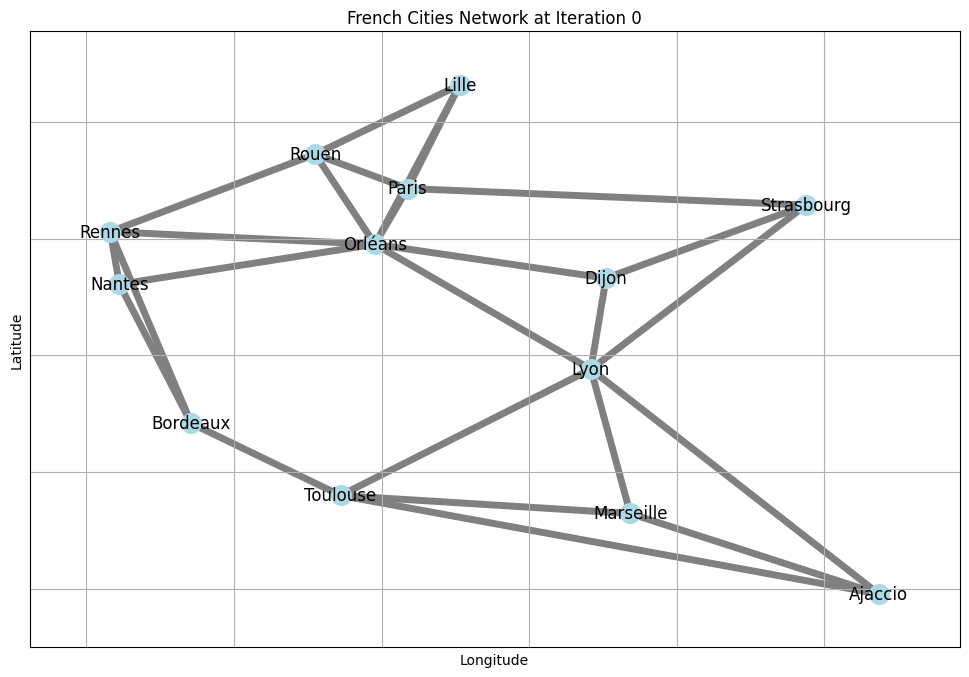

Converged after 54 iterations.


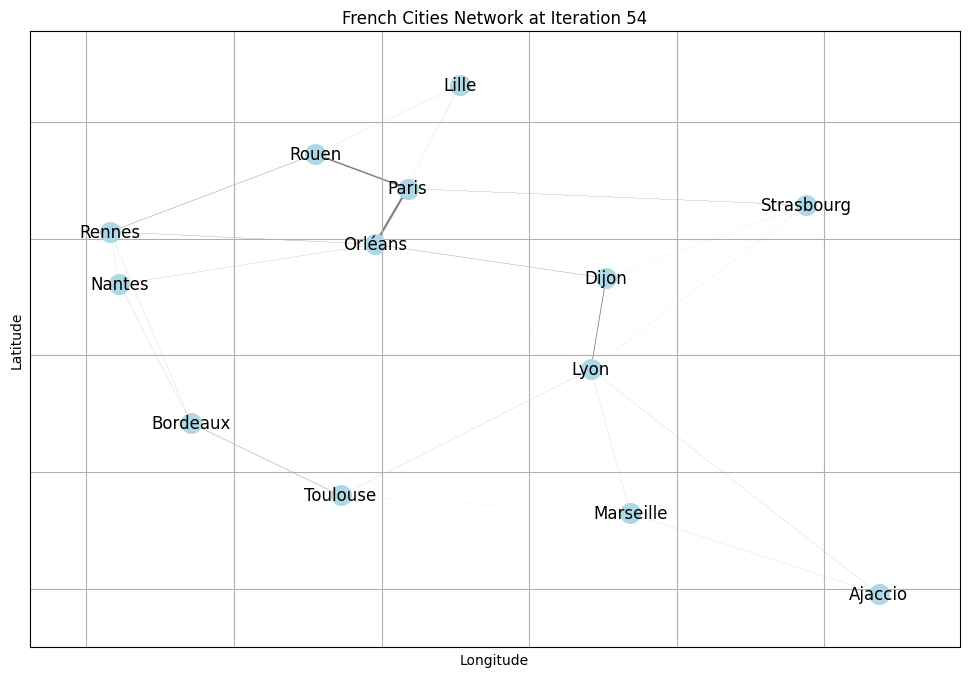


Final Conductivities (D_ij) on edges:
Edge Paris-Orléans: D_ij = 0.3044
Edge Paris-Rouen: D_ij = 0.2173
Edge Paris-Lille: D_ij = 0.0093
Edge Paris-Strasbourg: D_ij = 0.0339
Edge Lyon-Dijon: D_ij = 0.1178
Edge Lyon-Marseille: D_ij = 0.0176
Edge Lyon-Orléans: D_ij = 0.0042
Edge Lyon-Strasbourg: D_ij = 0.0095
Edge Lyon-Toulouse: D_ij = 0.0194
Edge Lyon-Ajaccio: D_ij = 0.0192
Edge Bordeaux-Toulouse: D_ij = 0.0557
Edge Bordeaux-Nantes: D_ij = 0.0209
Edge Bordeaux-Rennes: D_ij = 0.0180
Edge Lille-Rouen: D_ij = 0.0142
Edge Lille-Orléans: D_ij = 0.0091
Edge Marseille-Ajaccio: D_ij = 0.0147
Edge Marseille-Toulouse: D_ij = 0.0058
Edge Strasbourg-Dijon: D_ij = 0.0090
Edge Toulouse-Ajaccio: D_ij = 0.0054
Edge Nantes-Rennes: D_ij = 0.0116
Edge Nantes-Orléans: D_ij = 0.0251
Edge Rennes-Rouen: D_ij = 0.0536
Edge Rennes-Orléans: D_ij = 0.0399
Edge Rouen-Orléans: D_ij = 0.0042
Edge Orléans-Dijon: D_ij = 0.0468


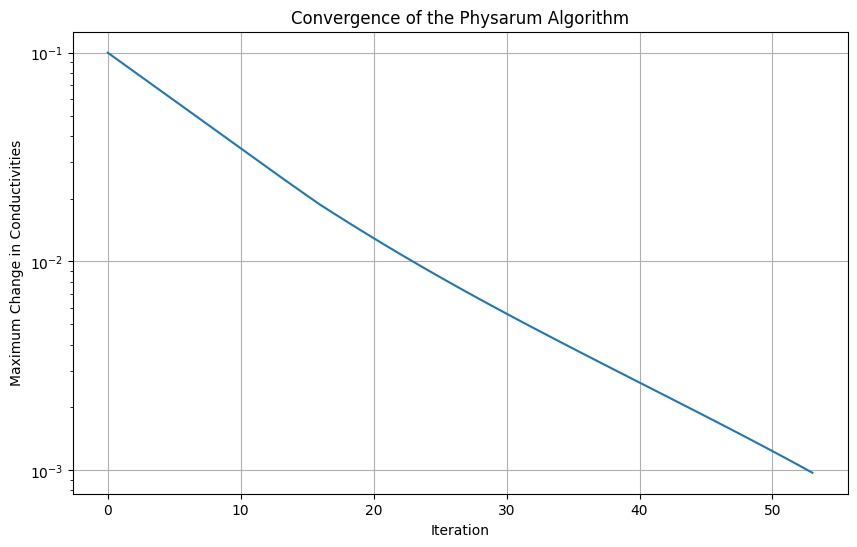

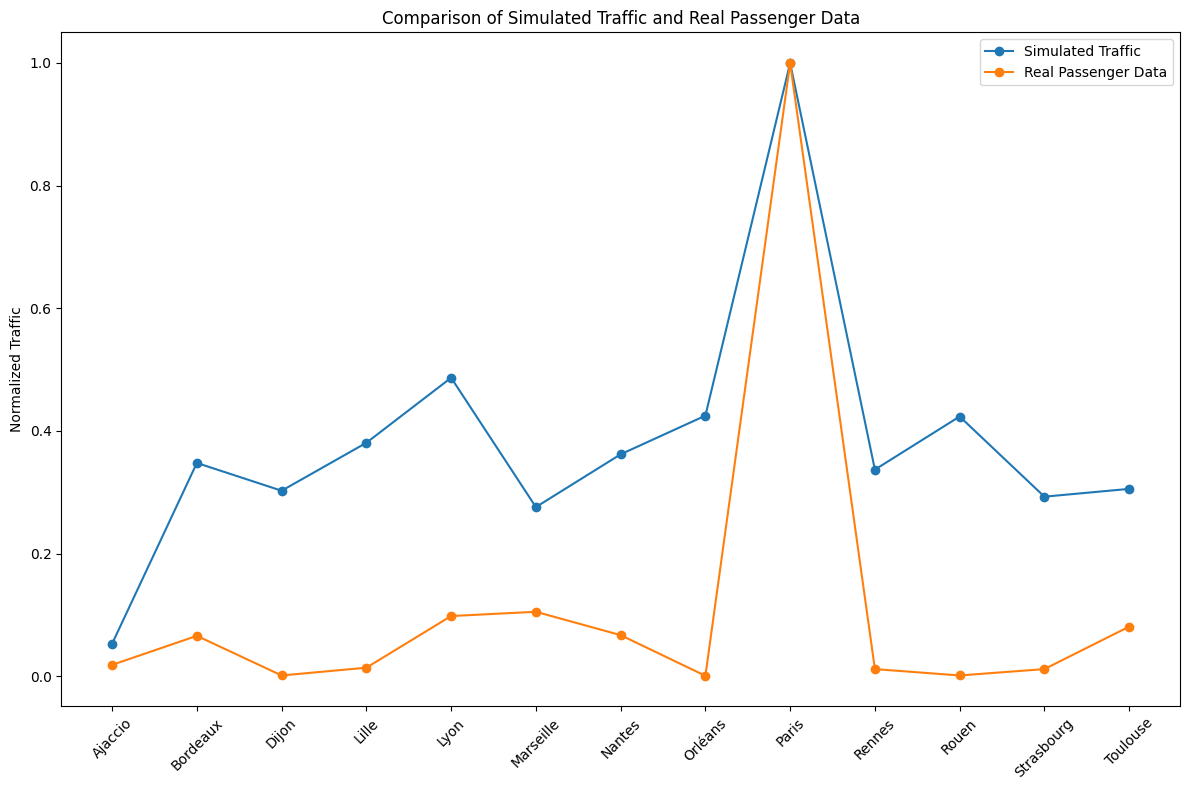

Correlation coefficient between simulated traffic and real passenger data: 0.8712


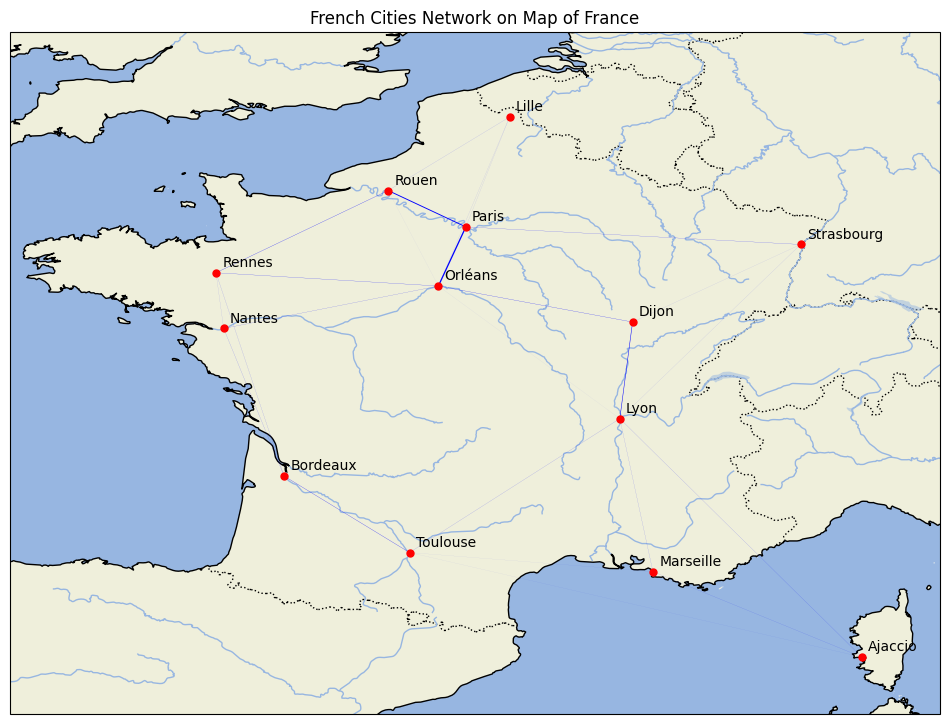

In [8]:
# ================================================
# Gravity Based Model 1: French Cities Network (maango4)
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a more comprehensive map of France with additional cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.
# In this version (maango4), the city data is provided from the user's input data.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances
import cartopy.crs as ccrs      # For mapping
import cartopy.feature as cfeature  # For adding features to the map

# ------------------------------------------------
# Step 1: Input City Data from User
# ------------------------------------------------

# User-provided data
data = [
    {"Capital City": "Paris", "GDP (in million euros)": 782639, "Passengers (2022)": 86664033, "Latitude (°N)": 48.8566, "Longitude (°E)": 2.3522, "Altitude (m)": 35},
    {"Capital City": "Lyon", "GDP (in million euros)": 287000, "Passengers (2022)": 8500000, "Latitude (°N)": 45.7640, "Longitude (°E)": 4.8357, "Altitude (m)": 162},
    {"Capital City": "Bordeaux", "GDP (in million euros)": 180000, "Passengers (2022)": 5700000, "Latitude (°N)": 44.8378, "Longitude (°E)": -0.5792, "Altitude (m)": 6},
    {"Capital City": "Lille", "GDP (in million euros)": 160000, "Passengers (2022)": 1200000, "Latitude (°N)": 50.6292, "Longitude (°E)": 3.0573, "Altitude (m)": 20},
    {"Capital City": "Marseille", "GDP (in million euros)": 156000, "Passengers (2022)": 9100000, "Latitude (°N)": 43.2965, "Longitude (°E)": 5.3698, "Altitude (m)": 28},
    {"Capital City": "Strasbourg", "GDP (in million euros)": 155000, "Passengers (2022)": 1000000, "Latitude (°N)": 48.5734, "Longitude (°E)": 7.7521, "Altitude (m)": 132},
    {"Capital City": "Toulouse", "GDP (in million euros)": 150000, "Passengers (2022)": 7000000, "Latitude (°N)": 43.6047, "Longitude (°E)": 1.4442, "Altitude (m)": 146},
    {"Capital City": "Nantes", "GDP (in million euros)": 120000, "Passengers (2022)": 5800000, "Latitude (°N)": 47.2184, "Longitude (°E)": -1.5536, "Altitude (m)": 8},
    {"Capital City": "Rennes", "GDP (in million euros)": 100000, "Passengers (2022)": 1000000, "Latitude (°N)": 48.1173, "Longitude (°E)": -1.6778, "Altitude (m)": 37},
    {"Capital City": "Rouen", "GDP (in million euros)": 90000, "Passengers (2022)": 100000, "Latitude (°N)": 49.4432, "Longitude (°E)": 1.0993, "Altitude (m)": 5},
    {"Capital City": "Orléans", "GDP (in million euros)": 80000, "Passengers (2022)": 50000, "Latitude (°N)": 47.9029, "Longitude (°E)": 1.9093, "Altitude (m)": 114},
    {"Capital City": "Dijon", "GDP (in million euros)": 70000, "Passengers (2022)": 100000, "Latitude (°N)": 47.3220, "Longitude (°E)": 5.0415, "Altitude (m)": 245},
    {"Capital City": "Ajaccio", "GDP (in million euros)": 10000, "Passengers (2022)": 1600000, "Latitude (°N)": 41.9192, "Longitude (°E)": 8.7386, "Altitude (m)": 38}
]

# ------------------------------------------------
# Step 2: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated GDP, passengers, and coordinates
cities = {}
for city_data in data:
    city_name = city_data["Capital City"]
    GDP = city_data["GDP (in million euros)"]
    passengers = city_data["Passengers (2022)"]
    lat = city_data["Latitude (°N)"]
    lon = city_data["Longitude (°E)"]
    G.add_node(city_name, GDP=GDP, lat=lat, lon=lon, passengers=passengers)
    cities[city_name] = {'GDP': GDP, 'lat': lat, 'lon': lon, 'passengers': passengers}

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 3: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 4: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Lists to store data for plotting
max_changes = []    # To store the maximum change in conductivities at each iteration
conductivity_history = {}  # To store conductivities over time

# Initialize conductivity history
for u, v in G.edges():
    conductivity_history[(u, v)] = [G[u][v]['D_ij']]

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = nodes[0]                         # Reference node (first node)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Record the conductivity history
        conductivity_history[(u, v)].append(D_ij_new)
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]
    # Edge colors set to grey
    edge_colors = ['grey' for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Add a title indicating the iteration number
    plt.title(f"French Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Record the maximum change for plotting
    max_changes.append(max_change)
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# ------------------------------------------------
# Step 5: Display Final Results
# ------------------------------------------------

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")

# ------------------------------------------------
# Step 6: Plotting Convergence Metrics
# ------------------------------------------------

# Plot the maximum change in conductivities over iterations
plt.figure(figsize=(10, 6))
plt.plot(max_changes)
plt.title("Convergence of the Physarum Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Maximum Change in Conductivities")
plt.yscale('log')
plt.grid(True)
plt.show()

# ------------------------------------------------
# Step 7: Compare Simulated Traffic with Real Data
# ------------------------------------------------

# Sum the traffic flows for each city (simulated data)
city_traffic_simulation = {city: 0.0 for city in G.nodes()}
for (origin, dest), flow in traffic_flows.items():
    city_traffic_simulation[origin] += flow
    city_traffic_simulation[dest] += flow

# Real passenger data for each city from the input
city_passengers = {city: data['passengers'] for city, data in G.nodes(data=True)}

# Normalize both datasets
max_simulated_traffic = max(city_traffic_simulation.values())
normalized_simulated_traffic = {city: flow / max_simulated_traffic for city, flow in city_traffic_simulation.items()}

max_passenger_traffic = max(city_passengers.values())
normalized_passenger_traffic = {city: passengers / max_passenger_traffic for city, passengers in city_passengers.items()}

# Ensure both datasets have the same cities
cities_list = sorted(G.nodes())

# Extract values in order
simulated_values = [normalized_simulated_traffic[city] for city in cities_list]
passenger_values = [normalized_passenger_traffic[city] for city in cities_list]

# Plot the comparison using line plots with dots
plt.figure(figsize=(12, 8))
x = np.arange(len(cities_list))  # the label locations

# Plot simulated traffic
plt.plot(x, simulated_values, marker='o', label='Simulated Traffic', linestyle='-')

# Plot real passenger data
plt.plot(x, passenger_values, marker='o', label='Real Passenger Data', linestyle='-')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Normalized Traffic')
plt.title('Comparison of Simulated Traffic and Real Passenger Data')
plt.xticks(x, cities_list, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Calculate and print the correlation coefficient
simulated_array = np.array(simulated_values)
passenger_array = np.array(passenger_values)
correlation = np.corrcoef(simulated_array, passenger_array)[0, 1]
print(f"Correlation coefficient between simulated traffic and real passenger data: {correlation:.4f}")

# ------------------------------------------------
# Step 8: Plot Network on Real Map of France
# ------------------------------------------------

# Function to plot the network on a real map of France
def plot_network_on_map(G):
    """
    Plot the network graph on a real map of France ensuring correct scaling.
    """
    plt.figure(figsize=(12, 10))
    # Define the map projection and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 41, 52])  # Longitude and latitude bounds of France

    # Add map features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plot the edges
    for u, v, data in G.edges(data=True):
        lon_u, lat_u = G.nodes[u]['lon'], G.nodes[u]['lat']
        lon_v, lat_v = G.nodes[v]['lon'], G.nodes[v]['lat']
        x_values = [lon_u, lon_v]
        y_values = [lat_u, lat_v]
        ax.plot(x_values, y_values, color='blue', linewidth=data['D_ij'] * 3, transform=ccrs.Geodetic())

    # Plot the nodes
    for city, data in G.nodes(data=True):
        ax.plot(data['lon'], data['lat'], marker='o', color='red', markersize=5, transform=ccrs.Geodetic())
        ax.text(data['lon'] + 0.1, data['lat'] + 0.1, city, transform=ccrs.Geodetic())

    plt.title('French Cities Network on Map of France')
    plt.show()

# Plot the network on the map
plot_network_on_map(G)


Traffic Flows (F_ij) between nodes (normalized):
From Paris to Lyon: 0.5111
From Paris to Bordeaux: 0.3174
From Paris to Lille: 0.7342
From Paris to Marseille: 0.2234
From Paris to Strasbourg: 0.3701
From Paris to Toulouse: 0.2460
From Paris to Nantes: 0.3775
From Paris to Rennes: 0.3834
From Paris to Rouen: 1.0000
From Paris to Orléans: 0.9520


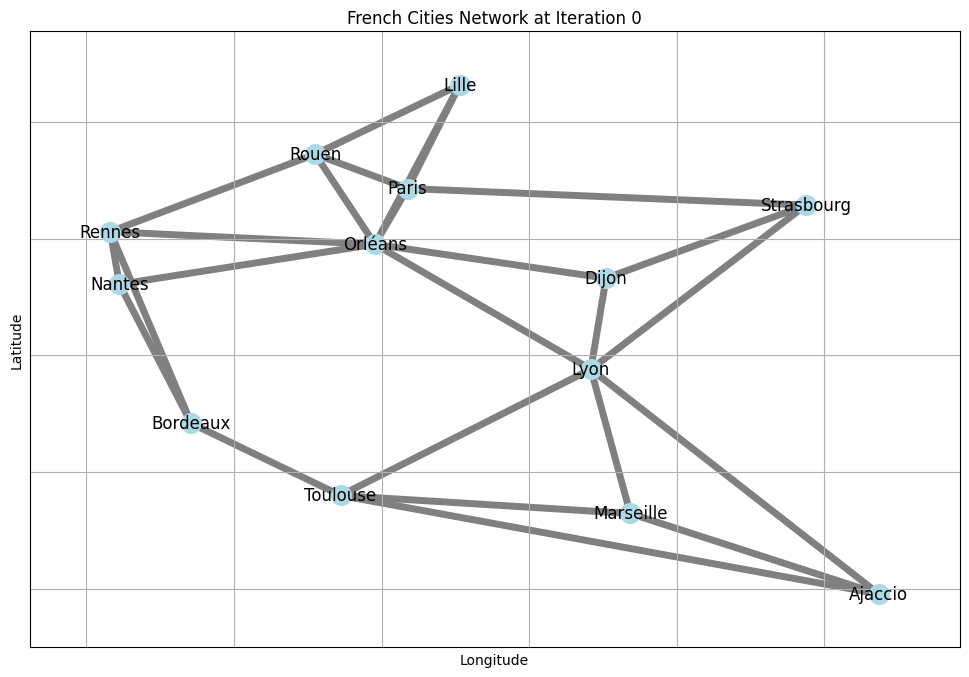

Converged after 54 iterations.


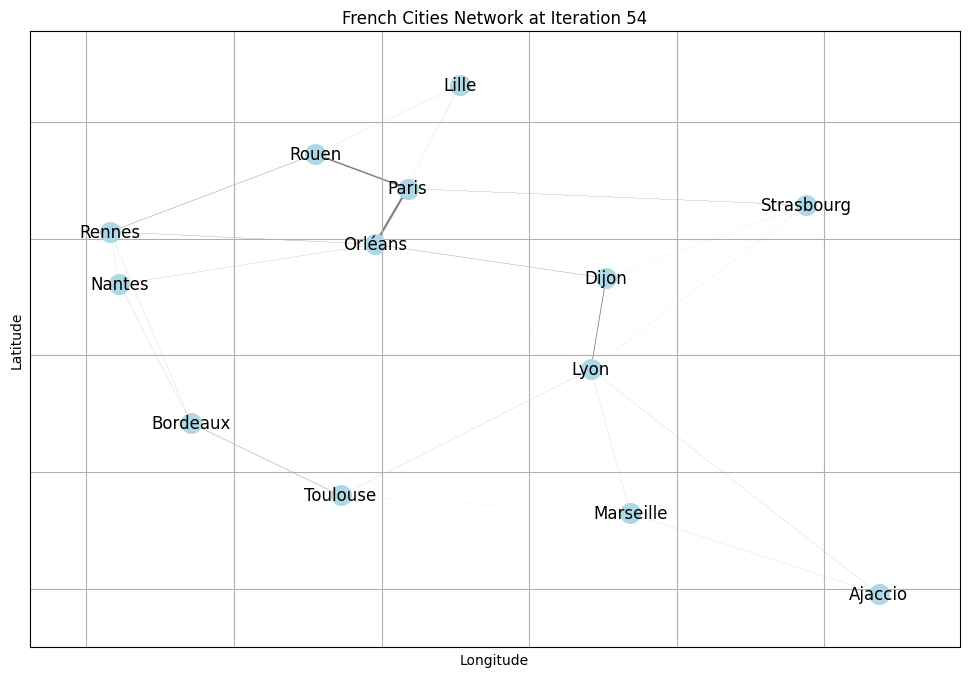


Final Conductivities (D_ij) on edges:
Edge Paris-Orléans: D_ij = 0.3044
Edge Paris-Rouen: D_ij = 0.2173
Edge Paris-Lille: D_ij = 0.0093
Edge Paris-Strasbourg: D_ij = 0.0339
Edge Lyon-Dijon: D_ij = 0.1178
Edge Lyon-Marseille: D_ij = 0.0176
Edge Lyon-Orléans: D_ij = 0.0042
Edge Lyon-Strasbourg: D_ij = 0.0095
Edge Lyon-Toulouse: D_ij = 0.0194
Edge Lyon-Ajaccio: D_ij = 0.0192
Edge Bordeaux-Toulouse: D_ij = 0.0557
Edge Bordeaux-Nantes: D_ij = 0.0209
Edge Bordeaux-Rennes: D_ij = 0.0180
Edge Lille-Rouen: D_ij = 0.0142
Edge Lille-Orléans: D_ij = 0.0091
Edge Marseille-Ajaccio: D_ij = 0.0147
Edge Marseille-Toulouse: D_ij = 0.0058
Edge Strasbourg-Dijon: D_ij = 0.0090
Edge Toulouse-Ajaccio: D_ij = 0.0054
Edge Nantes-Rennes: D_ij = 0.0116
Edge Nantes-Orléans: D_ij = 0.0251
Edge Rennes-Rouen: D_ij = 0.0536
Edge Rennes-Orléans: D_ij = 0.0399
Edge Rouen-Orléans: D_ij = 0.0042
Edge Orléans-Dijon: D_ij = 0.0468


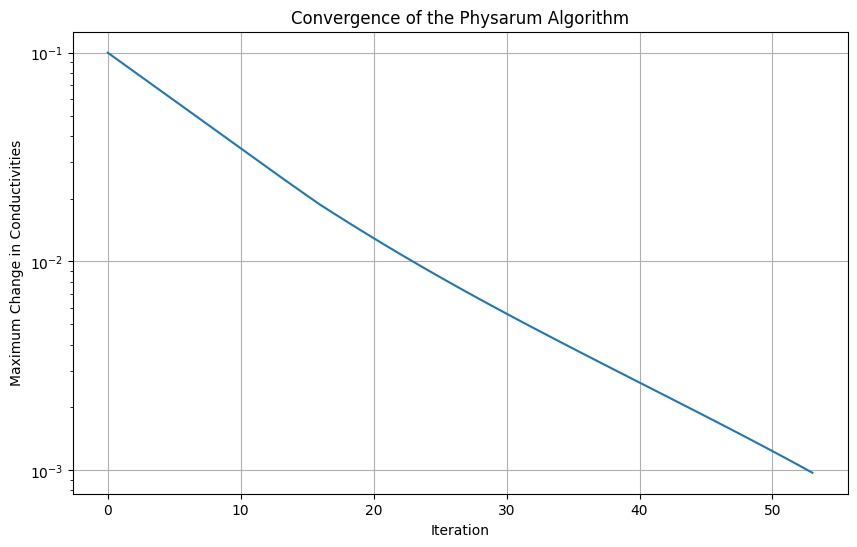

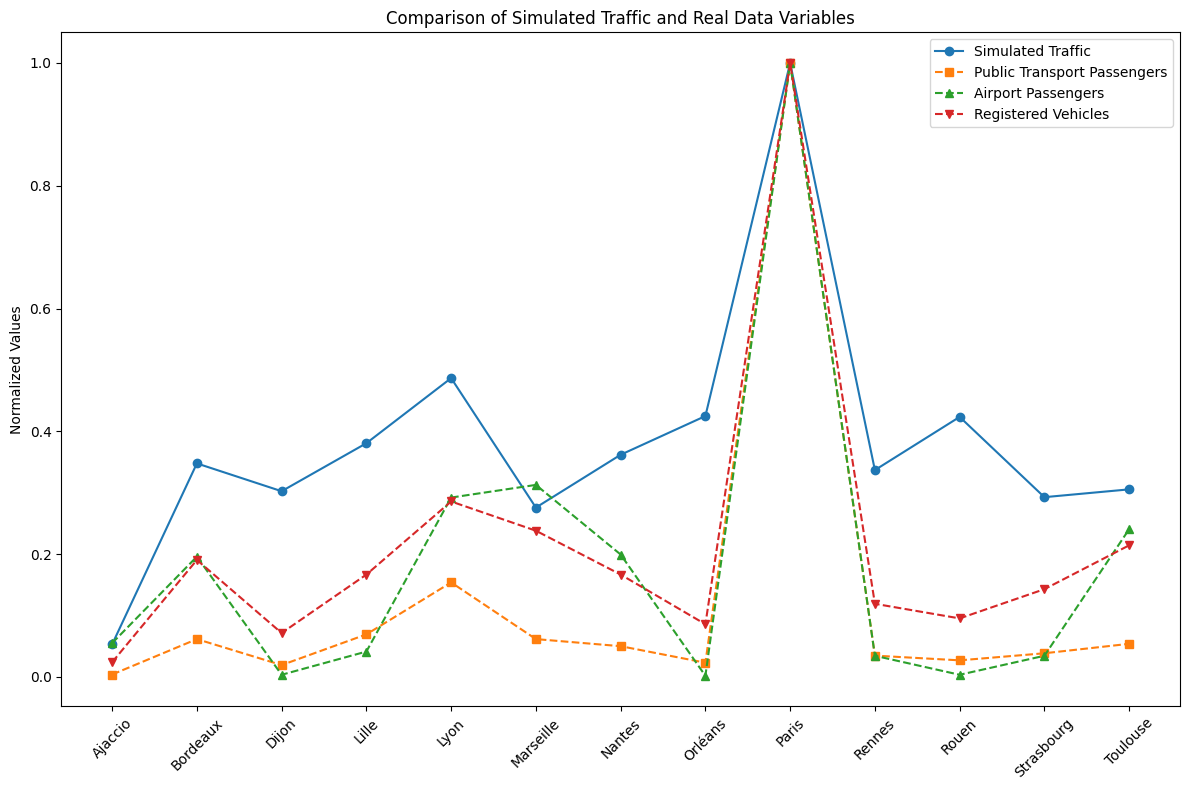

Correlation coefficients between simulated traffic and real data variables:
Public Transport Passengers: 0.9028
Airport Passengers: 0.8116
Registered Vehicles: 0.9029


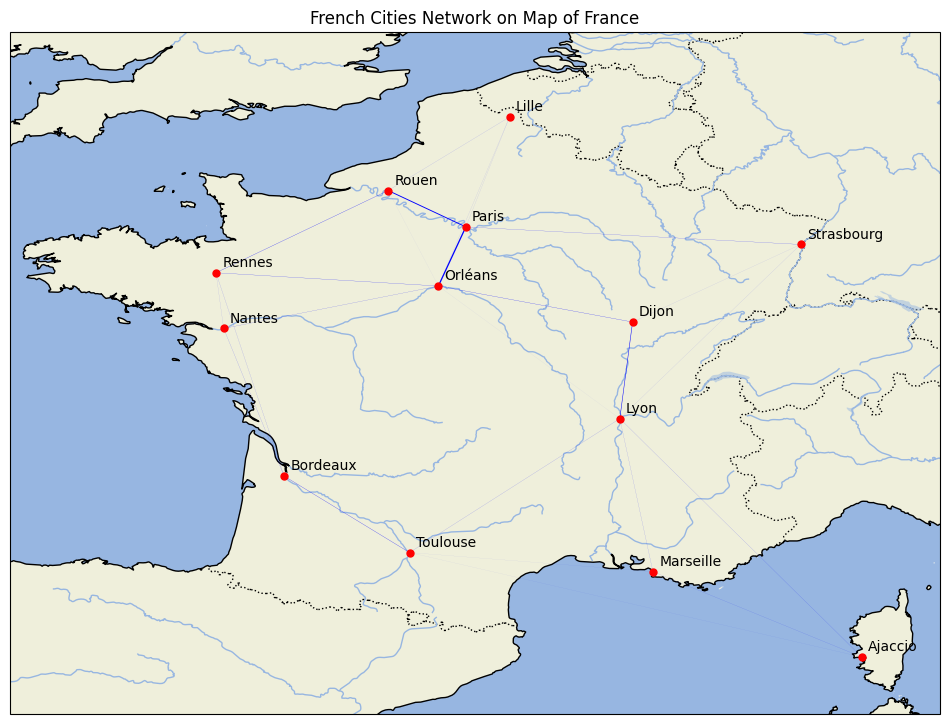

In [11]:
# ================================================
# Gravity Based Model 1: French Cities Network (maango5)
# ================================================

# This script implements the Physarum Polycephalum-inspired network design algorithm
# applied to a more comprehensive map of France with additional cities.
# It combines the gravity model with the Physarum algorithm to simulate
# the formation of efficient transportation networks between these cities.
# In this version (maango5), the city data includes additional variables,
# and we plot these variables together.

# ------------------------------------------------
# Import Necessary Libraries
# ------------------------------------------------

import numpy as np              # For numerical calculations
import networkx as nx           # For creating and manipulating graphs
import matplotlib.pyplot as plt # For visualizing the network
from math import radians, cos, sin, asin, sqrt  # For calculating distances
import cartopy.crs as ccrs      # For mapping
import cartopy.feature as cfeature  # For adding features to the map

# ------------------------------------------------
# Step 1: Input City Data from User
# ------------------------------------------------

# User-provided data (note: data for Orléans is completed with reasonable estimates)
data = [
    {"Capital City": "Paris", "GDP (in million euros)": 782639, "Public Transport Passengers (millions)": 2600, "Airport Passengers (millions)": 29.1, "Registered Vehicles (thousands)": 2100, "Latitude (°N)": 48.8566, "Longitude (°E)": 2.3522, "Altitude (m)": 35},
    {"Capital City": "Lyon", "GDP (in million euros)": 287000, "Public Transport Passengers (millions)": 400, "Airport Passengers (millions)": 8.5, "Registered Vehicles (thousands)": 600, "Latitude (°N)": 45.7640, "Longitude (°E)": 4.8357, "Altitude (m)": 162},
    {"Capital City": "Bordeaux", "GDP (in million euros)": 180000, "Public Transport Passengers (millions)": 160, "Airport Passengers (millions)": 5.7, "Registered Vehicles (thousands)": 400, "Latitude (°N)": 44.8378, "Longitude (°E)": -0.5792, "Altitude (m)": 6},
    {"Capital City": "Lille", "GDP (in million euros)": 160000, "Public Transport Passengers (millions)": 180, "Airport Passengers (millions)": 1.2, "Registered Vehicles (thousands)": 350, "Latitude (°N)": 50.6292, "Longitude (°E)": 3.0573, "Altitude (m)": 20},
    {"Capital City": "Marseille", "GDP (in million euros)": 156000, "Public Transport Passengers (millions)": 160, "Airport Passengers (millions)": 9.1, "Registered Vehicles (thousands)": 500, "Latitude (°N)": 43.2965, "Longitude (°E)": 5.3698, "Altitude (m)": 28},
    {"Capital City": "Strasbourg", "GDP (in million euros)": 155000, "Public Transport Passengers (millions)": 100, "Airport Passengers (millions)": 1.0, "Registered Vehicles (thousands)": 300, "Latitude (°N)": 48.5734, "Longitude (°E)": 7.7521, "Altitude (m)": 132},
    {"Capital City": "Toulouse", "GDP (in million euros)": 150000, "Public Transport Passengers (millions)": 140, "Airport Passengers (millions)": 7.0, "Registered Vehicles (thousands)": 450, "Latitude (°N)": 43.6047, "Longitude (°E)": 1.4442, "Altitude (m)": 146},
    {"Capital City": "Nantes", "GDP (in million euros)": 120000, "Public Transport Passengers (millions)": 130, "Airport Passengers (millions)": 5.8, "Registered Vehicles (thousands)": 350, "Latitude (°N)": 47.2184, "Longitude (°E)": -1.5536, "Altitude (m)": 8},
    {"Capital City": "Rennes", "GDP (in million euros)": 100000, "Public Transport Passengers (millions)": 90, "Airport Passengers (millions)": 1.0, "Registered Vehicles (thousands)": 250, "Latitude (°N)": 48.1173, "Longitude (°E)": -1.6778, "Altitude (m)": 37},
    {"Capital City": "Rouen", "GDP (in million euros)": 90000, "Public Transport Passengers (millions)": 70, "Airport Passengers (millions)": 0.1, "Registered Vehicles (thousands)": 200, "Latitude (°N)": 49.4432, "Longitude (°E)": 1.0993, "Altitude (m)": 5},
    {"Capital City": "Orléans", "GDP (in million euros)": 80000, "Public Transport Passengers (millions)": 60, "Airport Passengers (millions)": 0.05, "Registered Vehicles (thousands)": 180, "Latitude (°N)": 47.9029, "Longitude (°E)": 1.9093, "Altitude (m)": 114},
    {"Capital City": "Dijon", "GDP (in million euros)": 70000, "Public Transport Passengers (millions)": 50, "Airport Passengers (millions)": 0.1, "Registered Vehicles (thousands)": 150, "Latitude (°N)": 47.3220, "Longitude (°E)": 5.0415, "Altitude (m)": 245},
    {"Capital City": "Ajaccio", "GDP (in million euros)": 10000, "Public Transport Passengers (millions)": 10, "Airport Passengers (millions)": 1.6, "Registered Vehicles (thousands)": 50, "Latitude (°N)": 41.9192, "Longitude (°E)": 8.7386, "Altitude (m)": 38}
]

# ------------------------------------------------
# Step 2: Define the Network (Cities and Connections)
# ------------------------------------------------

# Create an undirected graph to represent the network
G = nx.Graph()

# Add nodes representing cities, each with associated data
cities = {}
for city_data in data:
    city_name = city_data["Capital City"]
    GDP = city_data["GDP (in million euros)"]
    public_transport_passengers = city_data["Public Transport Passengers (millions)"]
    airport_passengers = city_data["Airport Passengers (millions)"]
    registered_vehicles = city_data["Registered Vehicles (thousands)"]
    lat = city_data["Latitude (°N)"]
    lon = city_data["Longitude (°E)"]
    G.add_node(city_name,
               GDP=GDP,
               lat=lat,
               lon=lon,
               public_transport_passengers=public_transport_passengers,
               airport_passengers=airport_passengers,
               registered_vehicles=registered_vehicles)
    cities[city_name] = {
        'GDP': GDP,
        'lat': lat,
        'lon': lon,
        'public_transport_passengers': public_transport_passengers,
        'airport_passengers': airport_passengers,
        'registered_vehicles': registered_vehicles
    }

# Function to calculate the Haversine distance between two points
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth's surface given their latitude and longitude in degrees.
    """
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Manually define edges between cities
# We'll connect each city to its 3 nearest neighbors based on distance

# Function to find the N nearest neighbors for each city
def find_nearest_neighbors(G, N=3):
    edges = []
    nodes = list(G.nodes(data=True))
    for i, (city1, data1) in enumerate(nodes):
        distances = []
        for j, (city2, data2) in enumerate(nodes):
            if city1 != city2:
                dist = haversine_distance(data1['lat'], data1['lon'], data2['lat'], data2['lon'])
                distances.append((city2, dist))
        # Sort by distance and select N nearest neighbors
        distances.sort(key=lambda x: x[1])
        for k in range(N):
            neighbor_city, distance = distances[k]
            # To avoid duplicate edges, only add if not already present
            if not G.has_edge(city1, neighbor_city):
                edges.append((city1, neighbor_city, distance))
    return edges

# Find and add edges to the graph
edges = find_nearest_neighbors(G, N=3)  # Connect each city to its 3 nearest neighbors

# Add edges to the graph with calculated distances as lengths
for city1, city2, distance in edges:
    G.add_edge(city1, city2, length=distance)

# ------------------------------------------------
# Step 3: Gravity Model to Estimate Traffic Flows
# ------------------------------------------------

# The gravity model estimates the traffic flow between two cities based on their GDPs and distance.

# Parameters for the gravity model
alpha1 = 0.5  # Exponent for GDP of the origin city
alpha2 = 0.5  # Exponent for GDP of the destination city
alpha3 = 1    # Exponent for distance (distance decay)
r = 1         # Scaling constant

# Function to calculate traffic flows using the gravity model (unidirectional flows)
def calculate_traffic_flow(G, r, alpha1, alpha2, alpha3):
    """
    Calculate the traffic flows F_ij between nodes using the gravity model.
    """
    traffic_flows = {}          # Dictionary to store traffic flows F_ij
    nodes = list(G.nodes(data=True))     # List of all nodes with data

    for i, data_i in nodes:
        for j, data_j in nodes:
            if i != j and (i, j) not in traffic_flows and (j, i) not in traffic_flows:
                GDP_i = data_i['GDP']
                GDP_j = data_j['GDP']
                # Calculate the distance between the two cities
                dist = haversine_distance(data_i['lat'], data_i['lon'], data_j['lat'], data_j['lon'])
                # Compute F_ij using the gravity model formula
                F_ij = r * ((GDP_i ** alpha1) * (GDP_j ** alpha2)) / (dist ** alpha3)
                traffic_flows[(i, j)] = F_ij
    return traffic_flows

# Calculate the traffic flows between cities
traffic_flows = calculate_traffic_flow(G, r, alpha1, alpha2, alpha3)

# Normalize the traffic flows to prevent numerical instability
max_flow = max(traffic_flows.values())
traffic_flows = {k: v / max_flow for k, v in traffic_flows.items()}

# Display the calculated (normalized) traffic flows
print("Traffic Flows (F_ij) between nodes (normalized):")
for key, value in list(traffic_flows.items())[:10]:  # Display first 10 flows
    print(f"From {key[0]} to {key[1]}: {value:.4f}")

# ------------------------------------------------
# Step 4: Physarum Algorithm for Network Adaptation
# ------------------------------------------------

# Initialize the conductivities D_ij for each edge in the network
for u, v, data in G.edges(data=True):
    data['D_ij'] = 1.0          # Initial conductivity of the edge
    data['Q_ij'] = 0.0          # Initialize flux through the edge
    data['L_ij'] = data['length']  # Length of the edge as given

# Parameters for the Physarum algorithm
gamma = 10.0        # Decay rate
delta_t = 0.01      # Time step to control changes per iteration
max_iterations = 1000  # Maximum number of iterations
tolerance = 1e-3    # Tolerance for convergence

# Lists to store data for plotting
max_changes = []    # To store the maximum change in conductivities at each iteration
conductivity_history = {}  # To store conductivities over time

# Initialize conductivity history
for u, v in G.edges():
    conductivity_history[(u, v)] = [G[u][v]['D_ij']]

# Function to assemble the conductance matrix A and the right-hand side vector b
def assemble_conductance_matrix(G, F_ij):
    """
    Assemble the conductance matrix A and the right-hand side vector b for the system A*p = b.
    """
    nodes = list(G.nodes())                    # List of nodes
    n = len(nodes)                             # Number of nodes
    node_indices = {node: i for i, node in enumerate(nodes)}  # Mapping from node labels to indices
    A = np.zeros((n, n))                       # Initialize the conductance matrix A
    b = np.zeros(n)                            # Initialize the right-hand side vector b

    # Build the conductance matrix A based on the current conductivities
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        conductance = D_ij / L_ij              # Conductance between nodes u and v

        # Update the conductance matrix A
        A[i, i] += conductance                 # Add conductance to diagonal elements
        A[j, j] += conductance
        A[i, j] -= conductance                 # Subtract conductance from off-diagonal elements
        A[j, i] -= conductance

    # Apply traffic flows F_ij as sources and sinks in the system
    for (origin, dest), flow in F_ij.items():
        i = node_indices[origin]               # Index of origin node
        j = node_indices[dest]                 # Index of destination node
        b[i] -= flow                           # Source node (negative flow)
        b[j] += flow                           # Sink node (positive flow)

    # Fix the pressure at a reference node to zero to ensure a unique solution
    ref_node = nodes[0]                         # Reference node (first node)
    ref_index = node_indices[ref_node]         # Index of the reference node
    A[ref_index, :] = 0                        # Set the entire row corresponding to the reference node to zero
    A[ref_index, ref_index] = 1                # Set the diagonal element to one
    b[ref_index] = 0                           # Set the right-hand side value to zero

    return A, b, node_indices

# Function to calculate the fluxes Q_ij based on the current pressures
def calculate_fluxes(G, pressures, node_indices):
    """
    Calculate the flux Q_ij on each edge based on the pressures at the nodes.
    """
    for u, v, data in G.edges(data=True):
        i = node_indices[u]                    # Index of node u
        j = node_indices[v]                    # Index of node v
        D_ij = data['D_ij']                    # Conductivity of edge (u, v)
        L_ij = data['L_ij']                    # Length of edge (u, v)
        p_i = pressures[i]                     # Pressure at node i
        p_j = pressures[j]                     # Pressure at node j
        # Calculate the flux Q_ij using Ohm's law analogy
        Q_ij = D_ij * (p_i - p_j) / L_ij
        data['Q_ij'] = Q_ij                    # Store the flux in the edge data

# Function to update the conductivities D_ij based on the fluxes Q_ij
def update_conductivities(G):
    """
    Update the conductivities D_ij based on the fluxes Q_ij using the Physarum update rule.
    """
    max_change = 0.0                           # To keep track of the maximum change in conductivities
    D_ij_max = 10.0                            # Maximum allowable conductivity to prevent unbounded growth

    for u, v, data in G.edges(data=True):
        D_ij_old = data['D_ij']                # Previous conductivity of edge (u, v)
        Q_ij = data['Q_ij']                    # Flux through edge (u, v)
        # Update the conductivity D_ij using the equation from the article:
        # D_ij_new = D_ij_old + delta_t * (|Q_ij| - gamma * D_ij_old)
        D_ij_new = D_ij_old + delta_t * (abs(Q_ij) - gamma * D_ij_old)
        # Ensure the new conductivity stays within bounds (non-negative and below D_ij_max)
        D_ij_new = min(max(D_ij_new, 0.0), D_ij_max)
        data['D_ij'] = D_ij_new                # Update the conductivity in the edge data
        # Record the conductivity history
        conductivity_history[(u, v)].append(D_ij_new)
        # Calculate the change in conductivity to check for convergence
        change = abs(D_ij_new - D_ij_old)
        if change > max_change:
            max_change = change                # Update max_change if this change is the largest so far
    return max_change

# Function to visualize the network at a given iteration
def visualize_network(G, iteration):
    """
    Visualize the network, showing nodes and edges with conductivities represented by edge thickness.
    """
    plt.figure(figsize=(12, 8))
    pos = {city: (data['lon'], data['lat']) for city, data in G.nodes(data=True)}  # Use geographical positions
    # Scale edge widths based on conductivities for visualization
    edge_widths = [data['D_ij'] * 5 for _, _, data in G.edges(data=True)]
    # Edge colors set to grey
    edge_colors = ['grey' for _, _, data in G.edges(data=True)]

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    # Draw the edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)
    # Add labels to the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    # Add a title indicating the iteration number
    plt.title(f"French Cities Network at Iteration {iteration}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis('on')                            # Show axis
    plt.grid(True)
    plt.show()

# ------------------------------------------------
# Main Loop: Run the Physarum Algorithm
# ------------------------------------------------

# Visualize the initial network before any adaptation
visualize_network(G, iteration=0)

converged = False                              # Flag to indicate whether the algorithm has converged

# Iteratively update the network until convergence or maximum iterations reached
for iteration in range(1, max_iterations + 1):
    # Assemble the conductance matrix and the RHS vector based on current conductivities
    A, b, node_indices = assemble_conductance_matrix(G, traffic_flows)
    # Solve the linear system A * p = b to find the pressures at the nodes
    try:
        pressures = np.linalg.solve(A, b)
    except np.linalg.LinAlgError as e:
        print(f"Error solving linear system at iteration {iteration}: {e}")
        break
    # Calculate the fluxes on the edges based on the current pressures
    calculate_fluxes(G, pressures, node_indices)
    # Update the conductivities based on the fluxes
    max_change = update_conductivities(G)
    # Record the maximum change for plotting
    max_changes.append(max_change)
    # Check if the maximum change is below the convergence tolerance
    if max_change < tolerance:
        print(f"Converged after {iteration} iterations.")
        converged = True
        break

# If convergence was not reached within the maximum number of iterations
if not converged:
    print("Reached maximum iterations without full convergence.")

# ------------------------------------------------
# Step 5: Display Final Results
# ------------------------------------------------

# Visualize the final network after adaptation
visualize_network(G, iteration=iteration)

# Print the final conductivities of the edges
print("\nFinal Conductivities (D_ij) on edges:")
for u, v, data in G.edges(data=True):
    print(f"Edge {u}-{v}: D_ij = {data['D_ij']:.4f}")

# ------------------------------------------------
# Step 6: Plotting Convergence Metrics
# ------------------------------------------------

# Plot the maximum change in conductivities over iterations
plt.figure(figsize=(10, 6))
plt.plot(max_changes)
plt.title("Convergence of the Physarum Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Maximum Change in Conductivities")
plt.yscale('log')
plt.grid(True)
plt.show()

# ------------------------------------------------
# Step 7: Compare Simulated Traffic with Real Data
# ------------------------------------------------

# Sum the traffic flows for each city (simulated data)
city_traffic_simulation = {city: 0.0 for city in G.nodes()}
for (origin, dest), flow in traffic_flows.items():
    city_traffic_simulation[origin] += flow
    city_traffic_simulation[dest] += flow

# Real data for each city from the input
city_data_values = {}
for city, data in G.nodes(data=True):
    city_data_values[city] = {
        'public_transport_passengers': data['public_transport_passengers'],
        'airport_passengers': data['airport_passengers'],
        'registered_vehicles': data['registered_vehicles']
    }

# Normalize the datasets
max_simulated_traffic = max(city_traffic_simulation.values())
normalized_simulated_traffic = {city: flow / max_simulated_traffic for city, flow in city_traffic_simulation.items()}

# For each variable, normalize the data
variables = ['public_transport_passengers', 'airport_passengers', 'registered_vehicles']
normalized_real_data = {var: {} for var in variables}

for var in variables:
    max_value = max(city_data_values[city][var] for city in G.nodes())
    for city in G.nodes():
        normalized_real_data[var][city] = city_data_values[city][var] / max_value

# Ensure both datasets have the same cities
cities_list = sorted(G.nodes())

# Extract values in order
simulated_values = [normalized_simulated_traffic[city] for city in cities_list]

# Plot the comparison using line plots with dots
plt.figure(figsize=(12, 8))
x = np.arange(len(cities_list))  # the label locations

# Plot simulated traffic
plt.plot(x, simulated_values, marker='o', label='Simulated Traffic', linestyle='-')

# Plot each variable
markers = {'public_transport_passengers': 's', 'airport_passengers': '^', 'registered_vehicles': 'v'}
for var in variables:
    values = [normalized_real_data[var][city] for city in cities_list]
    plt.plot(x, values, marker=markers[var], label=var.replace('_', ' ').title(), linestyle='--')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Normalized Values')
plt.title('Comparison of Simulated Traffic and Real Data Variables')
plt.xticks(x, cities_list, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Calculate and print the correlation coefficients
print("Correlation coefficients between simulated traffic and real data variables:")
for var in variables:
    real_values = np.array([normalized_real_data[var][city] for city in cities_list])
    correlation = np.corrcoef(simulated_values, real_values)[0, 1]
    print(f"{var.replace('_', ' ').title()}: {correlation:.4f}")

# ------------------------------------------------
# Step 8: Plot Network on Real Map of France
# ------------------------------------------------

# Function to plot the network on a real map of France
def plot_network_on_map(G):
    """
    Plot the network graph on a real map of France ensuring correct scaling.
    """
    plt.figure(figsize=(12, 10))
    # Define the map projection and extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-5, 10, 41, 52])  # Longitude and latitude bounds of France

    # Add map features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    # Plot the edges
    for u, v, data in G.edges(data=True):
        lon_u, lat_u = G.nodes[u]['lon'], G.nodes[u]['lat']
        lon_v, lat_v = G.nodes[v]['lon'], G.nodes[v]['lat']
        x_values = [lon_u, lon_v]
        y_values = [lat_u, lat_v]
        ax.plot(x_values, y_values, color='blue', linewidth=data['D_ij'] * 3, transform=ccrs.Geodetic())

    # Plot the nodes
    for city, data in G.nodes(data=True):
        ax.plot(data['lon'], data['lat'], marker='o', color='red', markersize=5, transform=ccrs.Geodetic())
        ax.text(data['lon'] + 0.1, data['lat'] + 0.1, city, transform=ccrs.Geodetic())

    plt.title('French Cities Network on Map of France')
    plt.show()

# Plot the network on the map
plot_network_on_map(G)
